<a href="https://colab.research.google.com/github/au665243/uit-fitts-law/blob/master/BachelorData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount drive

In [171]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import libraries

In [172]:
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# Load data

In [173]:
mouse_df = pd.read_csv('/content/drive/MyDrive/MouseData.csv')
touch_df = pd.read_csv('/content/drive/MyDrive/TouchData.csv')
user_df = pd.read_csv('/content/drive/MyDrive/QuestionnaireData.csv')

In [174]:
user_df['Participant'] = user_df['Participant'].apply(lambda x: 'P{:02d}'.format(x))
user_df['Group'] = user_df['Group'].apply(lambda x: 'G{:02d}'.format(x))
user_df['UID'] = user_df['Participant'] + '-' + user_df['Group']

# Combine data

In [175]:
mouse_df = mouse_df.rename(columns={'IDe(bits)': 'IDe'})
common_cols = touch_df.columns.intersection(mouse_df.columns)
touch_df_common = touch_df.loc[:, common_cols]
mouse_df_common = mouse_df.loc[:, common_cols]
combined_df = pd.concat([touch_df_common, mouse_df_common], ignore_index=True)
combined_df['UID'] = combined_df['Participant'] + '-' + combined_df['Group']

In [176]:
# Select columns from user_df that are not in combined_df
user_cols = [col for col in user_df.columns if col not in combined_df.columns]

# Merge only the selected columns from user_df onto combined_df
merged_df = combined_df.merge(user_df[user_cols + ['UID']], on='UID')


# Clean data

In [177]:
merged_df['App'] = merged_df['App'].replace({'FittsTouch': 'touch', 'FittsTask': 'mouse'})
merged_df = merged_df.drop(['Session', 'Block', 'Condition', 'Trials', 'SRC', 'Female', 'Row'], axis=1)




In [178]:
print(merged_df.dtypes)


App               object
Participant       object
Group             object
A                float64
W                float64
ID               float64
Ae               float64
We               float64
IDe              float64
MT(ms)           float64
ER(%)            float64
TP(bps)          float64
UID               object
Age                int64
Male             float64
IT-experience     object
dtype: object


In [179]:
merged_df['Male'] = merged_df['Male'].fillna(0)


In [180]:
# create a boolean mask to identify the UIDs without both touch and mouse rows
mask = merged_df.groupby('UID')['App'].apply(lambda x: set(x) == {'touch', 'mouse'}).reset_index()

# select the UIDs that do not have both touch and mouse rows
uid_without_both = mask.loc[mask['App'] == False, 'UID']

# create a boolean mask to identify the rows with UIDs without both touch and mouse rows
mask = merged_df['UID'].isin(uid_without_both)

# delete the rows with UIDs without both touch and mouse rows
merged_df = merged_df.loc[~mask]


In [181]:
merged_df['IT-experience'] = merged_df['IT-experience'].map({'LOW': 1, 'MED': 2, 'HIGH': 3})

In [182]:
merged_df = merged_df.rename(columns={'MT(ms)': 'MT', 'ER(%)': 'ER', 'TP(bps)': 'TP', 'Male': 'Gender'})

cleaned_df = merged_df

# Splitting data

In [183]:
# Splitting based on 'App' and 'Group' conditions
touch_students_df = cleaned_df[(cleaned_df['App'] == 'touch') & (cleaned_df['Group'] == 'G01')].reset_index(drop=True)
touch_children_df = cleaned_df[(cleaned_df['App'] == 'touch') & (cleaned_df['Group'] == 'G02')].reset_index(drop=True)
touch_retirees_df = cleaned_df[(cleaned_df['App'] == 'touch') & (cleaned_df['Group'] == 'G03')].reset_index(drop=True)
mouse_students_df = cleaned_df[(cleaned_df['App'] == 'mouse') & (cleaned_df['Group'] == 'G01')].reset_index(drop=True)
mouse_children_df = cleaned_df[(cleaned_df['App'] == 'mouse') & (cleaned_df['Group'] == 'G02')].reset_index(drop=True)
mouse_retirees_df = cleaned_df[(cleaned_df['App'] == 'mouse') & (cleaned_df['Group'] == 'G03')].reset_index(drop=True)

touch_students_df

,App,Participant,Group,A,W,ID,Ae,We,IDe,MT,ER,TP,UID,Age,Gender,IT-experience
0,touch,P01,G01,221.90,221.90,1.00,211.66,81.97,1.84,343.69,0.0,5.36,P01-G01,23,1.0,3
1,touch,P01,G01,887.61,55.48,4.09,881.28,44.09,4.39,464.56,11.0,9.45,P01-G01,23,1.0,3
2,touch,P01,G01,221.90,55.48,2.32,222.50,42.40,2.64,323.00,0.0,8.18,P01-G01,23,1.0,3
3,touch,P01,G01,443.80,221.90,1.58,421.69,125.77,2.12,309.08,0.0,6.87,P01-G01,23,1.0,3
4,touch,P01,G01,887.61,110.95,3.17,859.26,101.10,3.25,358.04,11.0,9.07,P01-G01,23,1.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,touch,P22,G01,887.61,110.95,3.17,863.16,78.74,3.58,530.78,11.0,6.75,P22-G01,25,1.0,3
194,touch,P22,G01,221.90,221.90,1.00,236.49,54.13,2.42,432.49,0.0,5.61,P22-G01,25,1.0,3
195,touch,P22,G01,221.90,55.48,2.32,217.92,44.97,2.55,387.12,11.0,6.58,P22-G01,25,1.0,3
196,touch,P22,G01,443.80,55.48,3.17,430.07,97.39,2.44,371.15,44.0,6.57,P22-G01,25,1.0,3


# Removing quartile outliers ID

## Based on ID and MT

### Creating dataframe copies

In [184]:
# Create copies of the original dataframes
touch_students_mt_qo_df = touch_students_df.copy()
touch_children_mt_qo_df = touch_children_df.copy()
touch_retirees_mt_qo_df = touch_retirees_df.copy()
mouse_students_mt_qo_df = mouse_students_df.copy()
mouse_children_mt_qo_df = mouse_children_df.copy()
mouse_retirees_mt_qo_df = mouse_retirees_df.copy()


### Identifying outliers and storing in list

In [185]:
# List to store outliers for touch_students_df
removed_outliers_touch_students_mt = []

# Calculate outliers for touch_students_df
for id_value in touch_students_df['ID'].unique():
    subset_df = touch_students_df[touch_students_df['ID'] == id_value]
    q1 = subset_df['MT'].quantile(0.25)
    q3 = subset_df['MT'].quantile(0.75)
    iqr = q3 - q1
    lower_limit = q1 - 1.5 * iqr
    upper_limit = q3 + 1.5 * iqr
    outliers = subset_df[(subset_df['MT'] < lower_limit) | (subset_df['MT'] > upper_limit)]
    removed_outliers_touch_students_mt.extend(list(zip(outliers['UID'], outliers['MT'])))

# List to store outliers for touch_children_df
removed_outliers_touch_children_mt = []

# Calculate outliers for touch_children_df
for id_value in touch_children_df['ID'].unique():
    subset_df = touch_children_df[touch_children_df['ID'] == id_value]
    q1 = subset_df['MT'].quantile(0.25)
    q3 = subset_df['MT'].quantile(0.75)
    iqr = q3 - q1
    lower_limit = q1 - 1.5 * iqr
    upper_limit = q3 + 1.5 * iqr
    outliers = subset_df[(subset_df['MT'] < lower_limit) | (subset_df['MT'] > upper_limit)]
    removed_outliers_touch_children_mt.extend(list(zip(outliers['UID'], outliers['MT'])))

# List to store outliers for touch_retirees_df
removed_outliers_touch_retirees_mt = []

# Calculate outliers for touch_retirees_df
for id_value in touch_retirees_df['ID'].unique():
    subset_df = touch_retirees_df[touch_retirees_df['ID'] == id_value]
    q1 = subset_df['MT'].quantile(0.25)
    q3 = subset_df['MT'].quantile(0.75)
    iqr = q3 - q1
    lower_limit = q1 - 1.5 * iqr
    print(lower_limit)
    upper_limit = q3 + 1.5 * iqr
    print(upper_limit)
    outliers = subset_df[(subset_df['MT'] < lower_limit) | (subset_df['MT'] > upper_limit)]
    removed_outliers_touch_retirees_mt.extend(list(zip(outliers['UID'], outliers['MT'])))

# List to store outliers for mouse_students_df
removed_outliers_mouse_students_mt = []

# Calculate outliers for mouse_students_df
for id_value in mouse_students_df['ID'].unique():
    subset_df = mouse_students_df[mouse_students_df['ID'] == id_value]
    q1 = subset_df['MT'].quantile(0.25)
    q3 = subset_df['MT'].quantile(0.75)
    iqr = q3 - q1
    lower_limit = q1 - 1.5 * iqr
    upper_limit = q3 + 1.5 * iqr
    outliers = subset_df[(subset_df['MT'] < lower_limit) | (subset_df['MT'] > upper_limit)]
    removed_outliers_mouse_students_mt.extend(list(zip(outliers['UID'], outliers['MT'])))

# List to store outliers for mouse_children_df
removed_outliers_mouse_children_mt = []

# Calculate outliers for mouse_children_df
for id_value in mouse_children_df['ID'].unique():
    subset_df = mouse_children_df[mouse_children_df['ID'] == id_value]
    q1 = subset_df['MT'].quantile(0.25)
    q3 = subset_df['MT'].quantile(0.75)
    iqr = q3 - q1
    lower_limit = q1 - 1.5 * iqr
    upper_limit = q3 + 1.5 * iqr
    outliers = subset_df[(subset_df['MT'] < lower_limit) | (subset_df['MT'] > upper_limit)]
    removed_outliers_mouse_children_mt.extend(list(zip(outliers['UID'], outliers['MT'])))

# List to store outliers for mouse_retirees_df
removed_outliers_mouse_retirees_mt = []

# Calculate outliers for mouse_retirees_df
for id_value in mouse_retirees_df['ID'].unique():
    subset_df = mouse_retirees_df[mouse_retirees_df['ID'] == id_value]
    q1 = subset_df['MT'].quantile(0.25)
    q3 = subset_df['MT'].quantile(0.75)
    iqr = q3 - q1
    lower_limit = q1 - 1.5 * iqr
    upper_limit = q3 + 1.5 * iqr
    outliers = subset_df[(subset_df['MT'] < lower_limit) | (subset_df['MT'] > upper_limit)]
    removed_outliers_mouse_retirees_mt.extend(list(zip(outliers['UID'], outliers['MT'])))

# Print the removed outliers for touch_students_df
print("Removed outliers for touch_students_df:")
print(removed_outliers_touch_students_mt)

# Print the removed outliers for touch_children_df
print("Removed outliers for touch_children_df:")
print(removed_outliers_touch_children_mt)

# Print the removed outliers for touch_retirees_df
print("Removed outliers for touch_retirees_df:")
print(removed_outliers_touch_retirees_mt)

# Print the removed outliers for mouse_students_df
print("Removed outliers for mouse_students_df:")
print(removed_outliers_mouse_students_mt)

# Print the removed outliers for mouse_children_df
print("Removed outliers for mouse_children_df:")
print(removed_outliers_mouse_children_mt)

# Print the removed outliers for mouse_retirees_df
print("Removed outliers for mouse_retirees_df:")
print(removed_outliers_mouse_retirees_mt)



302.2075000000001
1190.9074999999998
226.67499999999995
1355.595
223.0887499999999
1129.59875
251.485
1586.7649999999999
604.99125
1380.38125
Removed outliers for touch_students_df:
[('P02-G01', 266.31)]
Removed outliers for touch_children_df:
[('P18-G02', 556.63), ('P01-G02', 914.75), ('P06-G02', 924.08), ('P01-G02', 793.2), ('P05-G02', 766.76), ('P12-G02', 766.75)]
Removed outliers for touch_retirees_df:
[('P01-G03', 1209.02), ('P13-G03', 1412.66), ('P13-G03', 1391.76), ('P06-G03', 1532.93), ('P13-G03', 1831.31), ('P13-G03', 1501.62), ('P13-G03', 1392.72), ('P13-G03', 1161.75), ('P13-G03', 1678.56), ('P13-G03', 3058.22)]
Removed outliers for mouse_students_df:
[('P04-G01', 682.56), ('P13-G01', 690.0), ('P17-G01', 764.33), ('P18-G01', 583.78)]
Removed outliers for mouse_children_df:
[('P01-G02', 6045.56), ('P01-G02', 2588.0), ('P03-G02', 2687.56), ('P05-G02', 2201.22), ('P09-G02', 3954.0), ('P01-G02', 4772.89), ('P01-G02', 5032.44), ('P03-G02', 2469.78), ('P05-G02', 2411.11), ('P14-G0

### Removing outliers from dataframes

In [186]:
# Remove outliers from touch_students_mt_qo_df
for outlier in removed_outliers_touch_students_mt:
    outlier_rows = touch_students_mt_qo_df[(touch_students_mt_qo_df['UID'] == outlier[0]) & (touch_students_mt_qo_df['MT'] == outlier[1])]
    if not outlier_rows.empty:
        touch_students_mt_qo_df = touch_students_mt_qo_df.drop(outlier_rows.index[0])

# Print the modified touch_students_mt_qo_df dataframe
print("Modified touch_students_mt_qo_df:")
print(touch_students_mt_qo_df)

# Repeat the same for other dataframes...

# Remove outliers from touch_children_mt_qo_df
for outlier in removed_outliers_touch_children_mt:
    outlier_rows = touch_children_mt_qo_df[(touch_children_mt_qo_df['UID'] == outlier[0]) & (touch_children_mt_qo_df['MT'] == outlier[1])]
    if not outlier_rows.empty:
        touch_children_mt_qo_df = touch_children_mt_qo_df.drop(outlier_rows.index[0])

# Print the modified touch_children_mt_qo_df dataframe
print("Modified touch_children_mt_qo_df:")
print(touch_children_mt_qo_df)

# Remove outliers from touch_retirees_mt_qo_df
for outlier in removed_outliers_touch_retirees_mt:
    outlier_rows = touch_retirees_mt_qo_df[(touch_retirees_mt_qo_df['UID'] == outlier[0]) & (touch_retirees_mt_qo_df['MT'] == outlier[1])]
    if not outlier_rows.empty:
        touch_retirees_mt_qo_df = touch_retirees_mt_qo_df.drop(outlier_rows.index[0])

# Print the modified touch_retirees_mt_qo_df dataframe
print("Modified touch_retirees_mt_qo_df:")
print(touch_retirees_mt_qo_df)

# Repeat the same for other dataframes...

# Remove outliers from mouse_students_mt_qo_df
for outlier in removed_outliers_mouse_students_mt:
    outlier_rows = mouse_students_mt_qo_df[(mouse_students_mt_qo_df['UID'] == outlier[0]) & (mouse_students_mt_qo_df['MT'] == outlier[1])]
    if not outlier_rows.empty:
        mouse_students_mt_qo_df = mouse_students_mt_qo_df.drop(outlier_rows.index[0])

# Print the modified mouse_students_mt_qo_df dataframe
print("Modified mouse_students_mt_qo_df:")
print(mouse_students_mt_qo_df)

# Repeat the same for other dataframes...

# Remove outliers from mouse_children_mt_qo_df
for outlier in removed_outliers_mouse_children_mt:
    outlier_rows = mouse_children_mt_qo_df[(mouse_children_mt_qo_df['UID'] == outlier[0]) & (mouse_children_mt_qo_df['MT'] == outlier[1])]
    if not outlier_rows.empty:
        mouse_children_mt_qo_df = mouse_children_mt_qo_df.drop(outlier_rows.index[0])

# Print the modified mouse_children_mt_qo_df dataframe
print("Modified mouse_children_mt_qo_df:")
print(mouse_children_mt_qo_df)

# Remove outliers from mouse_retirees_mt_qo_df
for outlier in removed_outliers_mouse_retirees_mt:
    outlier_rows = mouse_retirees_mt_qo_df[(mouse_retirees_mt_qo_df['UID'] == outlier[0]) & (mouse_retirees_mt_qo_df['MT'] == outlier[1])]
    if not outlier_rows.empty:
        mouse_retirees_mt_qo_df = mouse_retirees_mt_qo_df.drop(outlier_rows.index[0])

# Print the modified mouse_retirees_mt_qo_df dataframe
print("Modified mouse_retirees_mt_qo_df:")
print(mouse_retirees_mt_qo_df)


Modified touch_students_mt_qo_df:
       App Participant Group       A       W    ID      Ae      We   IDe  \
0    touch         P01   G01  221.90  221.90  1.00  211.66   81.97  1.84   
1    touch         P01   G01  887.61   55.48  4.09  881.28   44.09  4.39   
2    touch         P01   G01  221.90   55.48  2.32  222.50   42.40  2.64   
3    touch         P01   G01  443.80  221.90  1.58  421.69  125.77  2.12   
4    touch         P01   G01  887.61  110.95  3.17  859.26  101.10  3.25   
..     ...         ...   ...     ...     ...   ...     ...     ...   ...   
193  touch         P22   G01  887.61  110.95  3.17  863.16   78.74  3.58   
194  touch         P22   G01  221.90  221.90  1.00  236.49   54.13  2.42   
195  touch         P22   G01  221.90   55.48  2.32  217.92   44.97  2.55   
196  touch         P22   G01  443.80   55.48  3.17  430.07   97.39  2.44   
197  touch         P22   G01  443.80  221.90  1.58  427.51   97.36  2.43   

         MT    ER    TP      UID  Age  Gender  IT-exp

## Based on ID and ER

### Creating dataframe copies

In [187]:
# Create copies of the original dataframes
touch_students_er_qo_df = touch_students_df.copy()
touch_children_er_qo_df = touch_children_df.copy()
touch_retirees_er_qo_df = touch_retirees_df.copy()
mouse_students_er_qo_df = mouse_students_df.copy()
mouse_children_er_qo_df = mouse_children_df.copy()
mouse_retirees_er_qo_df = mouse_retirees_df.copy()


### Identifying outliers and storing in list

In [188]:
# List to store removed outliers for touch_students_df based on ER
removed_outliers_touch_students_er = []

# Calculate outliers for touch_students_df based on ER
for id_value in touch_students_df['ID'].unique():
    subset_df = touch_students_df[touch_students_df['ID'] == id_value]
    q1 = subset_df['ER'].quantile(0.25)
    q3 = subset_df['ER'].quantile(0.75)
    iqr = q3 - q1
    lower_limit = q1 - 1.5 * iqr
    upper_limit = q3 + 1.5 * iqr
    outliers = subset_df[(subset_df['ER'] < lower_limit) | (subset_df['ER'] > upper_limit)]
    removed_outliers_touch_students_er.extend(list(zip(outliers['UID'], outliers['ER'])))

# List to store removed outliers for touch_children_df based on ER
removed_outliers_touch_children_er = []

# Calculate outliers for touch_children_df based on ER
for id_value in touch_children_df['ID'].unique():
    subset_df = touch_children_df[touch_children_df['ID'] == id_value]
    q1 = subset_df['ER'].quantile(0.25)
    q3 = subset_df['ER'].quantile(0.75)
    iqr = q3 - q1
    lower_limit = q1 - 1.5 * iqr
    upper_limit = q3 + 1.5 * iqr
    outliers = subset_df[(subset_df['ER'] < lower_limit) | (subset_df['ER'] > upper_limit)]
    removed_outliers_touch_children_er.extend(list(zip(outliers['UID'], outliers['ER'])))

# List to store removed outliers for touch_retirees_df based on ER
removed_outliers_touch_retirees_er = []

# Calculate outliers for touch_retirees_df based on ER
for id_value in touch_retirees_df['ID'].unique():
    subset_df = touch_retirees_df[touch_retirees_df['ID'] == id_value]
    q1 = subset_df['ER'].quantile(0.25)
    q3 = subset_df['ER'].quantile(0.75)
    iqr = q3 - q1
    lower_limit = q1 - 1.5 * iqr
    upper_limit = q3 + 1.5 * iqr
    outliers = subset_df[(subset_df['ER'] < lower_limit) | (subset_df['ER'] > upper_limit)]
    removed_outliers_touch_retirees_er.extend(list(zip(outliers['UID'], outliers['ER'])))

# List to store removed outliers for mouse_students_df based on ER
removed_outliers_mouse_students_er = []

# Calculate outliers for mouse_students_df based on ER
for id_value in mouse_students_df['ID'].unique():
    subset_df = mouse_students_df[mouse_students_df['ID'] == id_value]
    q1 = subset_df['ER'].quantile(0.25)
    q3 = subset_df['ER'].quantile(0.75)
    iqr = q3 - q1
    lower_limit = q1 - 1.5 * iqr
    upper_limit = q3 + 1.5 * iqr
    outliers = subset_df[(subset_df['ER'] < lower_limit) | (subset_df['ER'] > upper_limit)]
    removed_outliers_mouse_students_er.extend(list(zip(outliers['UID'], outliers['ER'])))

# List to store removed outliers for mouse_students_df based on ER
removed_outliers_mouse_students_er = []

# Calculate outliers for mouse_students_df based on ER
for id_value in mouse_students_df['ID'].unique():
    subset_df = mouse_students_df[mouse_students_df['ID'] == id_value]
    q1 = subset_df['ER'].quantile(0.25)
    q3 = subset_df['ER'].quantile(0.75)
    iqr = q3 - q1
    lower_limit = q1 - 1.5 * iqr
    upper_limit = q3 + 1.5 * iqr
    outliers = subset_df[(subset_df['ER'] < lower_limit) | (subset_df['ER'] > upper_limit)]
    removed_outliers_mouse_students_er.extend(list(zip(outliers['UID'], outliers['ER'])))

# List to store removed outliers for mouse_children_df based on ER
removed_outliers_mouse_children_er = []

# Calculate outliers for mouse_children_df based on ER
for id_value in mouse_children_df['ID'].unique():
    subset_df = mouse_children_df[mouse_children_df['ID'] == id_value]
    q1 = subset_df['ER'].quantile(0.25)
    q3 = subset_df['ER'].quantile(0.75)
    iqr = q3 - q1
    lower_limit = q1 - 1.5 * iqr
    upper_limit = q3 + 1.5 * iqr
    outliers = subset_df[(subset_df['ER'] < lower_limit) | (subset_df['ER'] > upper_limit)]
    removed_outliers_mouse_children_er.extend(list(zip(outliers['UID'], outliers['ER'])))

# List to store removed outliers for mouse_retirees_df based on ER
removed_outliers_mouse_retirees_er = []

# Calculate outliers for mouse_retirees_df based on ER
for id_value in mouse_retirees_df['ID'].unique():
    subset_df = mouse_retirees_df[mouse_retirees_df['ID'] == id_value]
    q1 = subset_df['ER'].quantile(0.25)
    q3 = subset_df['ER'].quantile(0.75)
    iqr = q3 - q1
    lower_limit = q1 - 1.5 * iqr
    upper_limit = q3 + 1.5 * iqr
    outliers = subset_df[(subset_df['ER'] < lower_limit) | (subset_df['ER'] > upper_limit)]
    removed_outliers_mouse_retirees_er.extend(list(zip(outliers['UID'], outliers['ER'])))

# Print removed outliers for each dataframe
print("Removed outliers for touch_students_df based on ER:")
print(removed_outliers_touch_students_er)

print("Removed outliers for touch_children_df based on ER:")
print(removed_outliers_touch_children_er)

print("Removed outliers for touch_retirees_df based on ER:")
print(removed_outliers_touch_retirees_er)

print("Removed outliers for mouse_students_df based on ER:")
print(removed_outliers_mouse_students_er)

print("Removed outliers for mouse_children_df based on ER:")
print(removed_outliers_mouse_children_er)

print("Removed outliers for mouse_retirees_df based on ER:")
print(removed_outliers_mouse_retirees_er)



Removed outliers for touch_students_df based on ER:
[('P10-G01', 11.0), ('P01-G01', 11.0), ('P02-G01', 11.0), ('P04-G01', 11.0), ('P05-G01', 33.0), ('P06-G01', 11.0), ('P08-G01', 22.0), ('P10-G01', 11.0), ('P11-G01', 22.0), ('P14-G01', 11.0), ('P14-G01', 44.0), ('P19-G01', 11.0), ('P21-G01', 11.0), ('P22-G01', 11.0), ('P02-G01', 11.0), ('P02-G01', 22.0), ('P11-G01', 11.0), ('P11-G01', 11.0), ('P19-G01', 11.0), ('P21-G01', 11.0), ('P22-G01', 11.0), ('P02-G01', 67.0), ('P14-G01', 56.0)]
Removed outliers for touch_children_df based on ER:
[('P05-G02', 33.0), ('P06-G02', 33.0), ('P08-G02', 33.0), ('P11-G02', 56.0), ('P12-G02', 33.0), ('P01-G02', 11.0), ('P05-G02', 11.0), ('P13-G02', 22.0), ('P16-G02', 11.0), ('P03-G02', 56.0), ('P22-G02', 56.0)]
Removed outliers for touch_retirees_df based on ER:
[('P06-G03', 56.0), ('P09-G03', 44.0), ('P13-G03', 67.0), ('P18-G03', 33.0), ('P19-G03', 67.0), ('P20-G03', 56.0), ('P06-G03', 56.0), ('P13-G03', 56.0), ('P15-G03', 56.0), ('P19-G03', 67.0), ('P20

### Removing outliers from dataframes

In [189]:
# Remove outliers from touch_students_er_qo_df
for outlier in removed_outliers_touch_students_er:
    outlier_rows = touch_students_er_qo_df[(touch_students_er_qo_df['UID'] == outlier[0]) & (touch_students_er_qo_df['ER'] == outlier[1])]
    if not outlier_rows.empty:
        touch_students_er_qo_df = touch_students_er_qo_df.drop(outlier_rows.index[0])

# Print the modified touch_students_er_qo_df dataframe
print("Modified touch_students_er_qo_df:")
print(touch_students_er_qo_df)

# Repeat the same for other dataframes...

# Remove outliers from touch_children_er_qo_df
for outlier in removed_outliers_touch_children_er:
    outlier_rows = touch_children_er_qo_df[(touch_children_er_qo_df['UID'] == outlier[0]) & (touch_children_er_qo_df['ER'] == outlier[1])]
    if not outlier_rows.empty:
        touch_children_er_qo_df = touch_children_er_qo_df.drop(outlier_rows.index[0])

# Print the modified touch_children_er_qo_df dataframe
print("Modified touch_children_er_qo_df:")
print(touch_children_er_qo_df)

# Remove outliers from touch_retirees_er_qo_df
for outlier in removed_outliers_touch_retirees_er:
    outlier_rows = touch_retirees_er_qo_df[(touch_retirees_er_qo_df['UID'] == outlier[0]) & (touch_retirees_er_qo_df['ER'] == outlier[1])]
    if not outlier_rows.empty:
        touch_retirees_er_qo_df = touch_retirees_er_qo_df.drop(outlier_rows.index[0])

# Print the modified touch_retirees_er_qo_df dataframe
print("Modified touch_retirees_er_qo_df:")
print(touch_retirees_er_qo_df)

# Repeat the same for other dataframes...

# Remove outliers from mouse_students_er_qo_df
for outlier in removed_outliers_mouse_students_er:
    outlier_rows = mouse_students_er_qo_df[(mouse_students_er_qo_df['UID'] == outlier[0]) & (mouse_students_er_qo_df['ER'] == outlier[1])]
    if not outlier_rows.empty:
        mouse_students_er_qo_df = mouse_students_er_qo_df.drop(outlier_rows.index[0])

# Print the modified mouse_students_er_qo_df dataframe
print("Modified mouse_students_er_qo_df:")
print(mouse_students_er_qo_df)

# Repeat the same for other dataframes...

# Remove outliers from mouse_children_er_qo_df
for outlier in removed_outliers_mouse_children_er:
    outlier_rows = mouse_children_er_qo_df[(mouse_children_er_qo_df['UID'] == outlier[0]) & (mouse_children_er_qo_df['ER'] == outlier[1])]
    if not outlier_rows.empty:
        mouse_children_er_qo_df = mouse_children_er_qo_df.drop(outlier_rows.index[0])

# Print the modified mouse_children_er_qo_df dataframe
print("Modified mouse_children_er_qo_df:")
print(mouse_children_er_qo_df)

# Remove outliers from mouse_retirees_er_qo_df
for outlier in removed_outliers_mouse_retirees_er:
    outlier_rows = mouse_retirees_er_qo_df[(mouse_retirees_er_qo_df['UID'] == outlier[0]) & (mouse_retirees_er_qo_df['ER'] == outlier[1])]
    if not outlier_rows.empty:
        mouse_retirees_er_qo_df = mouse_retirees_er_qo_df.drop(outlier_rows.index[0])

# Print the modified mouse_retirees_er_qo_df dataframe
print("Modified mouse_retirees_er_qo_df:")
print(mouse_retirees_er_qo_df)


Modified touch_students_er_qo_df:
       App Participant Group       A       W    ID      Ae      We   IDe  \
0    touch         P01   G01  221.90  221.90  1.00  211.66   81.97  1.84   
2    touch         P01   G01  221.90   55.48  2.32  222.50   42.40  2.64   
3    touch         P01   G01  443.80  221.90  1.58  421.69  125.77  2.12   
4    touch         P01   G01  887.61  110.95  3.17  859.26  101.10  3.25   
5    touch         P01   G01  443.80  110.95  2.32  428.48   98.08  2.42   
..     ...         ...   ...     ...     ...   ...     ...     ...   ...   
191  touch         P22   G01  887.61  221.90  2.32  834.51  171.81  2.55   
192  touch         P22   G01  221.90  110.95  1.58  218.02   70.13  2.04   
194  touch         P22   G01  221.90  221.90  1.00  236.49   54.13  2.42   
196  touch         P22   G01  443.80   55.48  3.17  430.07   97.39  2.44   
197  touch         P22   G01  443.80  221.90  1.58  427.51   97.36  2.43   

         MT    ER    TP      UID  Age  Gender  IT-exp

## Based on ID and TP

### Creating dataframe copies

In [190]:
# Create copies of the original dataframes
touch_students_tp_qo_df = touch_students_df.copy()
touch_children_tp_qo_df = touch_children_df.copy()
touch_retirees_tp_qo_df = touch_retirees_df.copy()
mouse_students_tp_qo_df = mouse_students_df.copy()
mouse_children_tp_qo_df = mouse_children_df.copy()
mouse_retirees_tp_qo_df = mouse_retirees_df.copy()


### Identifying outliers and storing in list

In [191]:
# List to store removed outliers for touch_students_df based on TP
removed_outliers_touch_students_tp = []

# Calculate outliers for touch_students_df based on TP
for id_value in touch_students_df['ID'].unique():
    subset_df = touch_students_df[touch_students_df['ID'] == id_value]
    q1 = subset_df['TP'].quantile(0.25)
    q3 = subset_df['TP'].quantile(0.75)
    iqr = q3 - q1
    lower_limit = q1 - 1.5 * iqr
    upper_limit = q3 + 1.5 * iqr
    outliers = subset_df[(subset_df['TP'] < lower_limit) | (subset_df['TP'] > upper_limit)]
    removed_outliers_touch_students_tp.extend(list(zip(outliers['UID'], outliers['TP'])))

# List to store removed outliers for touch_children_df based on TP
removed_outliers_touch_children_tp = []

# Calculate outliers for touch_children_df based on TP
for id_value in touch_children_df['ID'].unique():
    subset_df = touch_children_df[touch_children_df['ID'] == id_value]
    q1 = subset_df['TP'].quantile(0.25)
    q3 = subset_df['TP'].quantile(0.75)
    iqr = q3 - q1
    lower_limit = q1 - 1.5 * iqr
    upper_limit = q3 + 1.5 * iqr
    outliers = subset_df[(subset_df['TP'] < lower_limit) | (subset_df['TP'] > upper_limit)]
    removed_outliers_touch_children_tp.extend(list(zip(outliers['UID'], outliers['TP'])))

# List to store removed outliers for touch_retirees_df based on TP
removed_outliers_touch_retirees_tp = []

# Calculate outliers for touch_retirees_df based on TP
for id_value in touch_retirees_df['ID'].unique():
    subset_df = touch_retirees_df[touch_retirees_df['ID'] == id_value]
    q1 = subset_df['TP'].quantile(0.25)
    q3 = subset_df['TP'].quantile(0.75)
    iqr = q3 - q1
    lower_limit = q1 - 1.5 * iqr
    upper_limit = q3 + 1.5 * iqr
    outliers = subset_df[(subset_df['TP'] < lower_limit) | (subset_df['TP'] > upper_limit)]
    removed_outliers_touch_retirees_tp.extend(list(zip(outliers['UID'], outliers['TP'])))

# List to store removed outliers for mouse_students_df based on TP
removed_outliers_mouse_students_tp = []

# Calculate outliers for mouse_students_df based on TP
for id_value in mouse_students_df['ID'].unique():
    subset_df = mouse_students_df[mouse_students_df['ID'] == id_value]
    q1 = subset_df['TP'].quantile(0.25)
    q3 = subset_df['TP'].quantile(0.75)
    iqr = q3 - q1
    lower_limit = q1 - 1.5 * iqr
    upper_limit = q3 + 1.5 * iqr
    outliers = subset_df[(subset_df['TP'] < lower_limit) | (subset_df['TP'] > upper_limit)]
    removed_outliers_mouse_students_tp.extend(list(zip(outliers['UID'], outliers['TP'])))

# List to store removed outliers for mouse_children_df based on TP
removed_outliers_mouse_children_tp = []

# Calculate outliers for mouse_children_df based on TP
for id_value in mouse_children_df['ID'].unique():
    subset_df = mouse_children_df[mouse_children_df['ID'] == id_value]
    q1 = subset_df['TP'].quantile(0.25)
    q3 = subset_df['TP'].quantile(0.75)
    iqr = q3 - q1
    lower_limit = q1 - 1.5 * iqr
    upper_limit = q3 + 1.5 * iqr
    outliers = subset_df[(subset_df['TP'] < lower_limit) | (subset_df['TP'] > upper_limit)]
    removed_outliers_mouse_children_tp.extend(list(zip(outliers['UID'], outliers['TP'])))

# List to store removed outliers for mouse_retirees_df based on TP
removed_outliers_mouse_retirees_tp = []

# Calculate outliers for mouse_retirees_df based on TP
for id_value in mouse_retirees_df['ID'].unique():
    subset_df = mouse_retirees_df[mouse_retirees_df['ID'] == id_value]
    q1 = subset_df['TP'].quantile(0.25)
    q3 = subset_df['TP'].quantile(0.75)
    iqr = q3 - q1
    lower_limit = q1 - 1.5 * iqr
    upper_limit = q3 + 1.5 * iqr
    outliers = subset_df[(subset_df['TP'] < lower_limit) | (subset_df['TP'] > upper_limit)]
    removed_outliers_mouse_retirees_tp.extend(list(zip(outliers['UID'], outliers['TP'])))

# Print the removed outliers for each dataframe based on TP
print("Removed Outliers (Mouse, Students, TP):", removed_outliers_mouse_students_tp)
print("Removed Outliers (Mouse, Children, TP):", removed_outliers_mouse_children_tp)
print("Removed Outliers (Mouse, Retirees, TP):", removed_outliers_mouse_retirees_tp)
print("Removed Outliers (Touch, Students, TP):", removed_outliers_touch_students_tp)
print("Removed Outliers (Touch, Children, TP):", removed_outliers_touch_children_tp)
print("Removed Outliers (Touch, Retirees, TP):", removed_outliers_touch_retirees_tp)



Removed Outliers (Mouse, Students, TP): [('P07-G01', 5.03), ('P12-G01', 6.35), ('P01-G01', 1.12), ('P04-G01', 0.81), ('P07-G01', 0.86), ('P09-G01', 0.91), ('P15-G01', 0.87), ('P19-G01', 1.11), ('P02-G01', 0.84), ('P06-G01', 0.94), ('P09-G01', 1.22), ('P09-G01', 1.15), ('P10-G01', 1.09), ('P14-G01', 0.89), ('P14-G01', 1.22), ('P15-G01', 0.98), ('P20-G01', 1.2), ('P10-G01', 1.02), ('P16-G01', 0.85), ('P19-G01', 1.0), ('P20-G01', 0.39), ('P22-G01', 7.06)]
Removed Outliers (Mouse, Children, TP): [('P22-G02', 3.3), ('P20-G02', 3.48), ('P22-G02', 3.64), ('P01-G02', 0.21)]
Removed Outliers (Mouse, Retirees, TP): [('P20-G03', 2.86), ('P01-G03', 0.67), ('P14-G03', 4.12)]
Removed Outliers (Touch, Students, TP): [('P12-G01', 6.89), ('P20-G01', 10.98), ('P03-G01', 9.25), ('P20-G01', 11.64)]
Removed Outliers (Touch, Children, TP): [('P15-G02', 6.69), ('P18-G02', 7.02), ('P11-G02', 0.52), ('P23-G02', 10.07), ('P09-G02', 6.87), ('P11-G02', 0.65), ('P15-G02', 7.1), ('P18-G02', 7.11), ('P23-G02', 7.38)

### Removing outliers from dataframes

In [192]:
# Remove outliers from touch_students_tp_qo_df
for outlier in removed_outliers_touch_students_tp:
    outlier_rows = touch_students_tp_qo_df[(touch_students_tp_qo_df['UID'] == outlier[0]) & (touch_students_tp_qo_df['TP'] == outlier[1])]
    if not outlier_rows.empty:
        touch_students_tp_qo_df = touch_students_tp_qo_df.drop(outlier_rows.index[0])

# Print the modified touch_students_tp_qo_df dataframe
print("Modified touch_students_tp_qo_df:")
print(touch_students_tp_qo_df)

# Repeat the same for other dataframes...

# Remove outliers from touch_children_tp_qo_df
for outlier in removed_outliers_touch_children_tp:
    outlier_rows = touch_children_tp_qo_df[(touch_children_tp_qo_df['UID'] == outlier[0]) & (touch_children_tp_qo_df['TP'] == outlier[1])]
    if not outlier_rows.empty:
        touch_children_tp_qo_df = touch_children_tp_qo_df.drop(outlier_rows.index[0])

# Print the modified touch_children_tp_qo_df dataframe
print("Modified touch_children_tp_qo_df:")
print(touch_children_tp_qo_df)

# Remove outliers from touch_retirees_tp_qo_df
for outlier in removed_outliers_touch_retirees_tp:
    outlier_rows = touch_retirees_tp_qo_df[(touch_retirees_tp_qo_df['UID'] == outlier[0]) & (touch_retirees_tp_qo_df['TP'] == outlier[1])]
    if not outlier_rows.empty:
        touch_retirees_tp_qo_df = touch_retirees_tp_qo_df.drop(outlier_rows.index[0])

# Print the modified touch_retirees_tp_qo_df dataframe
print("Modified touch_retirees_tp_qo_df:")
print(touch_retirees_tp_qo_df)

# Repeat the same for other dataframes...

# Remove outliers from mouse_students_tp_qo_df
for outlier in removed_outliers_mouse_students_tp:
    outlier_rows = mouse_students_tp_qo_df[(mouse_students_tp_qo_df['UID'] == outlier[0]) & (mouse_students_tp_qo_df['TP'] == outlier[1])]
    if not outlier_rows.empty:
        mouse_students_tp_qo_df = mouse_students_tp_qo_df.drop(outlier_rows.index[0])

# Print the modified mouse_students_tp_qo_df dataframe
print("Modified mouse_students_tp_qo_df:")
print(mouse_students_tp_qo_df)

# Repeat the same for other dataframes...

# Remove outliers from mouse_children_tp_qo_df
for outlier in removed_outliers_mouse_children_tp:
    outlier_rows = mouse_children_tp_qo_df[(mouse_children_tp_qo_df['UID'] == outlier[0]) & (mouse_children_tp_qo_df['TP'] == outlier[1])]
    if not outlier_rows.empty:
        mouse_children_tp_qo_df = mouse_children_tp_qo_df.drop(outlier_rows.index[0])

# Print the modified mouse_children_tp_qo_df dataframe
print("Modified mouse_children_tp_qo_df:")
print(mouse_children_tp_qo_df)

# Remove outliers from mouse_retirees_tp_qo_df
for outlier in removed_outliers_mouse_retirees_tp:
    outlier_rows = mouse_retirees_tp_qo_df[(mouse_retirees_tp_qo_df['UID'] == outlier[0]) & (mouse_retirees_tp_qo_df['TP'] == outlier[1])]
    if not outlier_rows.empty:
        mouse_retirees_tp_qo_df = mouse_retirees_tp_qo_df.drop(outlier_rows.index[0])

# Print the modified mouse_retirees_tp_qo_df dataframe
print("Modified mouse_retirees_tp_qo_df:")
print(mouse_retirees_tp_qo_df)


Modified touch_students_tp_qo_df:
       App Participant Group       A       W    ID      Ae      We   IDe  \
0    touch         P01   G01  221.90  221.90  1.00  211.66   81.97  1.84   
1    touch         P01   G01  887.61   55.48  4.09  881.28   44.09  4.39   
2    touch         P01   G01  221.90   55.48  2.32  222.50   42.40  2.64   
3    touch         P01   G01  443.80  221.90  1.58  421.69  125.77  2.12   
4    touch         P01   G01  887.61  110.95  3.17  859.26  101.10  3.25   
..     ...         ...   ...     ...     ...   ...     ...     ...   ...   
193  touch         P22   G01  887.61  110.95  3.17  863.16   78.74  3.58   
194  touch         P22   G01  221.90  221.90  1.00  236.49   54.13  2.42   
195  touch         P22   G01  221.90   55.48  2.32  217.92   44.97  2.55   
196  touch         P22   G01  443.80   55.48  3.17  430.07   97.39  2.44   
197  touch         P22   G01  443.80  221.90  1.58  427.51   97.36  2.43   

         MT    ER    TP      UID  Age  Gender  IT-exp

# Visualization

In [193]:
#!pip install pandas-profiling[notebook]

In [194]:
#import ydata_profiling

# Generate a Pandas Profiling report
#profile = pandas_profiling.ProfileReport(cleaned_df)

# Save the report to an HTML file
#profile.to_file('report.html')

In [195]:
#from IPython.display import HTML
#HTML(filename="report.html")

In [196]:
#import matplotlib.pyplot as plt

# Calculate the average MT for each gender
#avg_MT_by_gender = cleaned_df.groupby('Male')['MT'].mean()

# Create a bar chart with value labels
#plt.bar(avg_MT_by_gender.index, avg_MT_by_gender.values, color='blue')
#for i, v in enumerate(avg_MT_by_gender.values):
#    plt.text(i, v, "{:.2f}".format(v), ha='center', va='bottom', fontweight='bold')
#plt.xlabel('Gender')
#plt.ylabel('Average MT (ms)')
#plt.title('Average MT by Male')
#plt.show()

In [197]:
#pip install plotly

# Statistics

## Goodness of fit

### Students

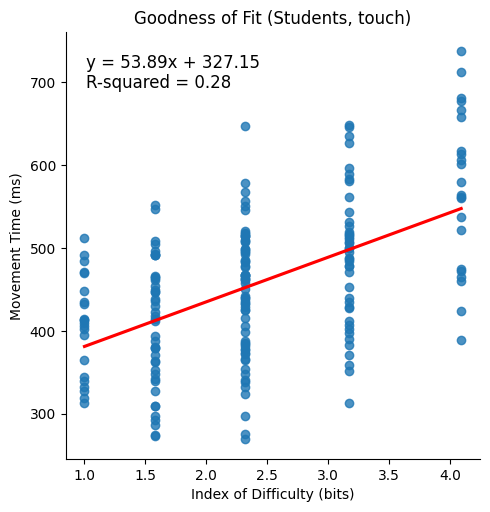

In [198]:
# Create the plot using seaborn
lm_plot = sns.lmplot(x='ID', y='MT', data=touch_students_mt_qo_df, ci=None, line_kws={'color': 'red'})

# Calculate the linear regression equation and R-squared value
slope, intercept, r_value, p_value, std_err = stats.linregress(touch_students_mt_qo_df['ID'], touch_students_mt_qo_df['MT'])
r_squared = r_value**2

# Add the equation and R-squared value to the plot
ax = plt.gca()
ax.text(0.05, 0.95, f"y = {slope:.2f}x + {intercept:.2f}\nR-squared = {r_squared:.2f}",
        transform=ax.transAxes, fontsize=12, verticalalignment='top')

# Set the labels and title of the plot
plt.xlabel("Index of Difficulty (bits)")
plt.ylabel("Movement Time (ms)")
plt.title("Goodness of Fit (Students, touch)")

# Show the plot
plt.show()


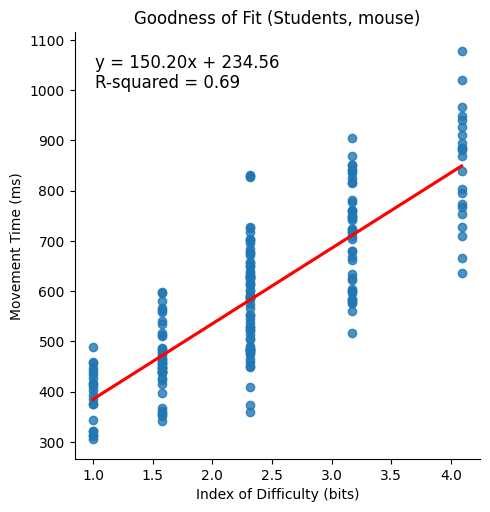

In [199]:
# create the plot using seaborn
sns.lmplot(x='ID', y='MT', data=mouse_students_mt_qo_df, ci=None, line_kws={'color': 'red'})

# calculate the linear regression equation and R-squared value
slope, intercept, r_value, p_value, std_err = stats.linregress(mouse_students_mt_qo_df['ID'], mouse_students_mt_qo_df['MT'])
r_squared = r_value**2

# add the equation and R-squared value to the plot
ax = plt.gca()
ax.text(0.05, 0.95, f"y = {slope:.2f}x + {intercept:.2f}\nR-squared = {r_squared:.2f}",
        transform=ax.transAxes, fontsize=12, verticalalignment='top')

# set the labels and title of the plot
plt.xlabel("Index of Difficulty (bits)")
plt.ylabel("Movement Time (ms)")
plt.title("Goodness of Fit (Students, mouse)")

# show the plot
plt.show()


### Children

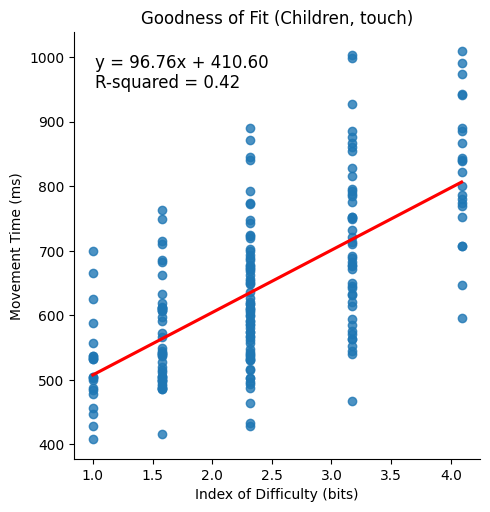

In [200]:
# create the plot using seaborn
sns.lmplot(x='ID', y='MT', data=touch_children_mt_qo_df, ci=None, line_kws={'color': 'red'})

# calculate the linear regression equation and R-squared value
slope, intercept, r_value, p_value, std_err = stats.linregress(touch_children_mt_qo_df['ID'], touch_children_mt_qo_df['MT'])
r_squared = r_value**2

# add the equation and R-squared value to the plot
ax = plt.gca()
ax.text(0.05, 0.95, f"y = {slope:.2f}x + {intercept:.2f}\nR-squared = {r_squared:.2f}",
        transform=ax.transAxes, fontsize=12, verticalalignment='top')

# set the labels and title of the plot
plt.xlabel("Index of Difficulty (bits)")
plt.ylabel("Movement Time (ms)")
plt.title("Goodness of Fit (Children, touch)")

# show the plot
plt.show()


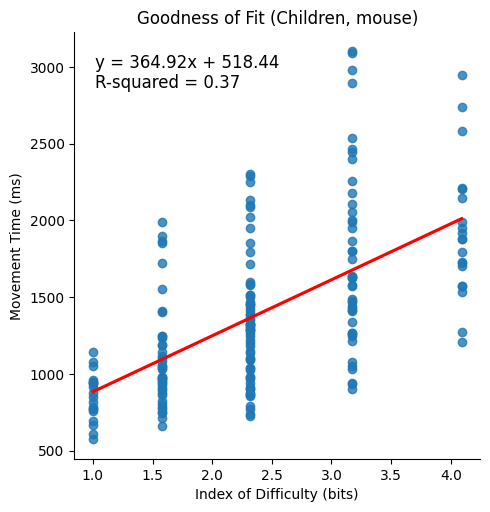

In [201]:
# create the plot using seaborn
sns.lmplot(x='ID', y='MT', data=mouse_children_mt_qo_df, ci=None, line_kws={'color': 'red'})

# calculate the linear regression equation and R-squared value
slope, intercept, r_value, p_value, std_err = stats.linregress(mouse_children_mt_qo_df['ID'], mouse_children_mt_qo_df['MT'])
r_squared = r_value**2

# add the equation and R-squared value to the plot
ax = plt.gca()
ax.text(0.05, 0.95, f"y = {slope:.2f}x + {intercept:.2f}\nR-squared = {r_squared:.2f}",
        transform=ax.transAxes, fontsize=12, verticalalignment='top')

# set the labels and title of the plot
plt.xlabel("Index of Difficulty (bits)")
plt.ylabel("Movement Time (ms)")
plt.title("Goodness of Fit (Children, mouse)")

# show the plot
plt.show()


### Retirees

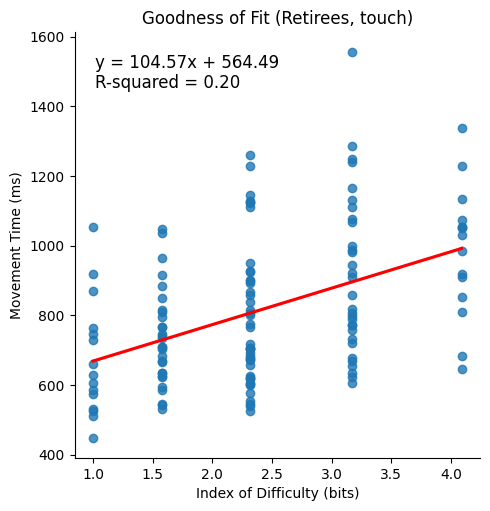

In [202]:
# create the plot using seaborn for touch_retirees_mt_qo_df
sns.lmplot(x='ID', y='MT', data=touch_retirees_mt_qo_df, ci=None, line_kws={'color': 'red'})

# calculate the linear regression equation and R-squared value
slope, intercept, r_value, p_value, std_err = stats.linregress(touch_retirees_mt_qo_df['ID'], touch_retirees_mt_qo_df['MT'])
r_squared = r_value**2

# add the equation and R-squared value to the plot
ax = plt.gca()
ax.text(0.05, 0.95, f"y = {slope:.2f}x + {intercept:.2f}\nR-squared = {r_squared:.2f}",
        transform=ax.transAxes, fontsize=12, verticalalignment='top')

# set the labels and title of the plot for retirees
plt.xlabel("Index of Difficulty (bits)")
plt.ylabel("Movement Time (ms)")
plt.title("Goodness of Fit (Retirees, touch)")

# show the plot
plt.show()


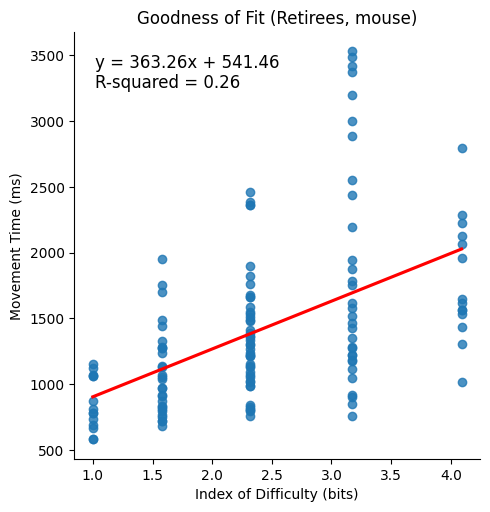

In [203]:
# create the plot using seaborn for mouse_retirees_mt_qo_df
sns.lmplot(x='ID', y='MT', data=mouse_retirees_mt_qo_df, ci=None, line_kws={'color': 'red'})

# calculate the linear regression equation and R-squared value
slope, intercept, r_value, p_value, std_err = stats.linregress(mouse_retirees_mt_qo_df['ID'], mouse_retirees_mt_qo_df['MT'])
r_squared = r_value**2

# add the equation and R-squared value to the plot
ax = plt.gca()
ax.text(0.05, 0.95, f"y = {slope:.2f}x + {intercept:.2f}\nR-squared = {r_squared:.2f}",
        transform=ax.transAxes, fontsize=12, verticalalignment='top')

# set the labels and title of the plot for retirees
plt.xlabel("Index of Difficulty (bits)")
plt.ylabel("Movement Time (ms)")
plt.title("Goodness of Fit (Retirees, mouse)")

# show the plot
plt.show()


## Goodness of fit - mean MT

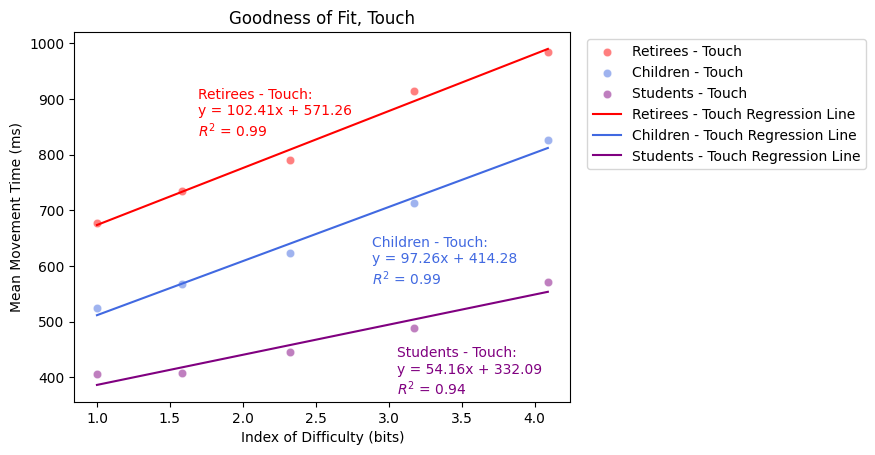

In [204]:
# Calculate the mean of MT for each ID for touch data
mean_mt_touch_retirees = touch_retirees_mt_qo_df.groupby('ID')['MT'].mean().reset_index()
mean_mt_touch_children = touch_children_mt_qo_df.groupby('ID')['MT'].mean().reset_index()
mean_mt_touch_students = touch_students_mt_qo_df.groupby('ID')['MT'].mean().reset_index()

# Set the desired color for the data points
data_points_color_retirees = 'red'
data_points_color_children = 'royalblue'
data_points_color_students = 'purple'

# Create the plot using seaborn
sns.scatterplot(x='ID', y='MT', data=mean_mt_touch_retirees, alpha=0.5, label='Retirees - Touch', color=data_points_color_retirees)
sns.scatterplot(x='ID', y='MT', data=mean_mt_touch_children, alpha=0.5, label='Children - Touch', color=data_points_color_children)
sns.scatterplot(x='ID', y='MT', data=mean_mt_touch_students, alpha=0.5, label='Students - Touch', color=data_points_color_students)

# Calculate the linear regression equation and R-squared value using the mean MT for touch data - Retirees
slope_touch_retirees, intercept_touch_retirees, r_value_touch_retirees, p_value_touch_retirees, std_err_touch_retirees = stats.linregress(mean_mt_touch_retirees['ID'], mean_mt_touch_retirees['MT'])
r_squared_touch_retirees = r_value_touch_retirees**2

# Calculate the linear regression equation and R-squared value using the mean MT for touch data - Children
slope_touch_children, intercept_touch_children, r_value_touch_children, p_value_touch_children, std_err_touch_children = stats.linregress(mean_mt_touch_children['ID'], mean_mt_touch_children['MT'])
r_squared_touch_children = r_value_touch_children**2

# Calculate the linear regression equation and R-squared value using the mean MT for touch data - Students
slope_touch_students, intercept_touch_students, r_value_touch_students, p_value_touch_students, std_err_touch_students = stats.linregress(mean_mt_touch_students['ID'], mean_mt_touch_students['MT'])
r_squared_touch_students = r_value_touch_students**2

# Plot the linear regression line for touch data - Retirees
x_touch_retirees = mean_mt_touch_retirees['ID']
y_touch_retirees = slope_touch_retirees * x_touch_retirees + intercept_touch_retirees
plt.plot(x_touch_retirees, y_touch_retirees, color='red', label='Retirees - Touch Regression Line')

# Plot the linear regression line for touch data - Children
x_touch_children = mean_mt_touch_children['ID']
y_touch_children = slope_touch_children * x_touch_children + intercept_touch_children
plt.plot(x_touch_children, y_touch_children, color='royalblue', label='Children - Touch Regression Line')

# Plot the linear regression line for touch data - Students
x_touch_students = mean_mt_touch_students['ID']
y_touch_students = slope_touch_students * x_touch_students + intercept_touch_students
plt.plot(x_touch_students, y_touch_students, color='purple', label='Students - Touch Regression Line')

# Add the equation and R-squared value to the plot for touch data - Retirees
ax = plt.gca()
ax.text(0.25, 0.85, f"Retirees - Touch:\ny = {slope_touch_retirees:.2f}x + {intercept_touch_retirees:.2f}\n$R^2$ = {r_squared_touch_retirees:.2f}",
        transform=ax.transAxes, fontsize=10, verticalalignment='top', color='red')

# Add the equation and R-squared value to the plot for touch data - Children
ax.text(0.60, 0.45, f"Children - Touch:\ny = {slope_touch_children:.2f}x + {intercept_touch_children:.2f}\n$R^2$ = {r_squared_touch_children:.2f}",
        transform=ax.transAxes, fontsize=10, verticalalignment='top', color='royalblue')

# Add the equation and R-squared value to the plot for touch data - Students
ax.text(0.65, 0.15, f"Students - Touch:\ny = {slope_touch_students:.2f}x + {intercept_touch_students:.2f}\n$R^2$ = {r_squared_touch_students:.2f}",
        transform=ax.transAxes, fontsize=10, verticalalignment='top', color='purple')

# Set the labels and title of the plot
plt.xlabel("Index of Difficulty (bits)")
plt.ylabel("Mean Movement Time (ms)")
plt.title("Goodness of Fit, Touch")

# Show the legend with the box moved to the right
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')

# Show the plot
plt.show()


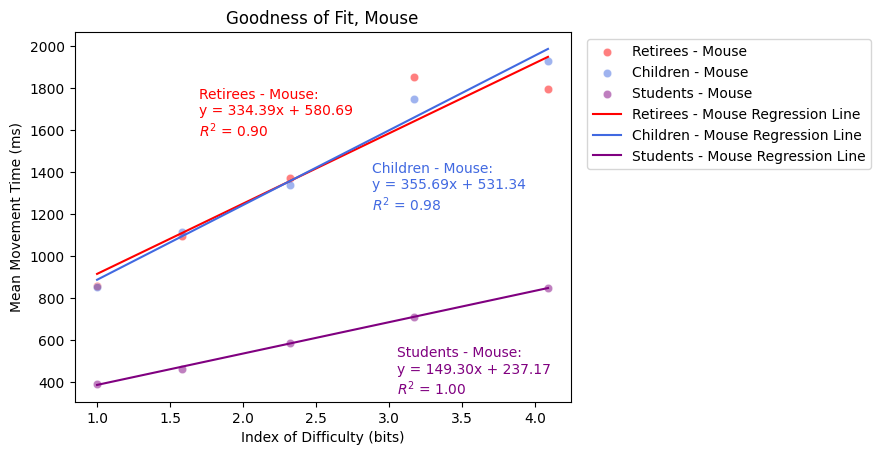

In [205]:
# Calculate the mean of MT for each ID for touch data
mean_mt_mouse_retirees = mouse_retirees_mt_qo_df.groupby('ID')['MT'].mean().reset_index()

# Calculate the mean of MT for each ID for touch data
mean_mt_mouse_children = mouse_children_mt_qo_df.groupby('ID')['MT'].mean().reset_index()

# Calculate the mean of MT for each ID for touch data
mean_mt_mouse_students = mouse_students_mt_qo_df.groupby('ID')['MT'].mean().reset_index()

# Set the desired color for the data points
data_points_color_retirees = 'red'
data_points_color_children = 'royalblue'
data_points_color_students = 'purple'

# Create the plot using seaborn
sns.scatterplot(x='ID', y='MT', data=mean_mt_mouse_retirees, alpha=0.5, label='Retirees - Mouse', color=data_points_color_retirees)
sns.scatterplot(x='ID', y='MT', data=mean_mt_mouse_children, alpha=0.5, label='Children - Mouse', color=data_points_color_children)
sns.scatterplot(x='ID', y='MT', data=mean_mt_mouse_students, alpha=0.5, label='Students - Mouse', color=data_points_color_students)

# Calculate the linear regression equation and R-squared value using the mean MT for touch data - Retirees
slope_mouse_retirees, intercept_mouse_retirees, r_value_mouse_retirees, p_value_mouse_retirees, std_err_mouse_retirees = stats.linregress(mean_mt_mouse_retirees['ID'], mean_mt_mouse_retirees['MT'])
r_squared_mouse_retirees = r_value_mouse_retirees**2

# Calculate the linear regression equation and R-squared value using the mean MT for touch data - Children
slope_mouse_children, intercept_mouse_children, r_value_mouse_children, p_value_mouse_children, std_err_mouse_children = stats.linregress(mean_mt_mouse_children['ID'], mean_mt_mouse_children['MT'])
r_squared_mouse_children = r_value_mouse_children**2

# Calculate the linear regression equation and R-squared value using the mean MT for touch data - Students
slope_mouse_students, intercept_mouse_students, r_value_mouse_students, p_value_mouse_students, std_err_mouse_students = stats.linregress(mean_mt_mouse_students['ID'], mean_mt_mouse_students['MT'])
r_squared_mouse_students = r_value_mouse_students**2

# Plot the linear regression line for touch data - Retirees
x_mouse_retirees = mean_mt_mouse_retirees['ID']
y_mouse_retirees = slope_mouse_retirees * x_mouse_retirees + intercept_mouse_retirees
plt.plot(x_mouse_retirees, y_mouse_retirees, color='red', label='Retirees - Mouse Regression Line')

# Plot the linear regression line for touch data - Children
x_mouse_children = mean_mt_mouse_children['ID']
y_mouse_children = slope_mouse_children * x_mouse_children + intercept_mouse_children
plt.plot(x_mouse_children, y_mouse_children, color='royalblue', label='Children - Mouse Regression Line')

# Plot the linear regression line for touch data - Students
x_mouse_students = mean_mt_mouse_students['ID']
y_mouse_students = slope_mouse_students * x_mouse_students + intercept_mouse_students
plt.plot(x_mouse_students, y_mouse_students, color='purple', label='Students - Mouse Regression Line')

# Add the equation and R-squared value to the plot for touch data - Retirees
ax = plt.gca()
ax.text(0.25, 0.85, f"Retirees - Mouse:\ny = {slope_mouse_retirees:.2f}x + {intercept_mouse_retirees:.2f}\n$R^2$ = {r_squared_mouse_retirees:.2f}",
        transform=ax.transAxes, fontsize=10, verticalalignment='top', color='red')

# Add the equation and R-squared value to the plot for touch data - Children
ax.text(0.60, 0.65, f"Children - Mouse:\ny = {slope_mouse_children:.2f}x + {intercept_mouse_children:.2f}\n$R^2$ = {r_squared_mouse_children:.2f}",
        transform=ax.transAxes, fontsize=10, verticalalignment='top', color='royalblue')

# Add the equation and R-squared value to the plot for touch data - Students
ax.text(0.65, 0.15, f"Students - Mouse:\ny = {slope_mouse_students:.2f}x + {intercept_mouse_students:.2f}\n$R^2$ = {r_squared_mouse_students:.2f}",
        transform=ax.transAxes, fontsize=10, verticalalignment='top', color='purple')

# Set the labels and title of the plot
plt.xlabel("Index of Difficulty (bits)")
plt.ylabel("Mean Movement Time (ms)")
plt.title("Goodness of Fit, Mouse")

# Show the legend with the box moved to the right
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')

# Show the plot
plt.show()



## TP

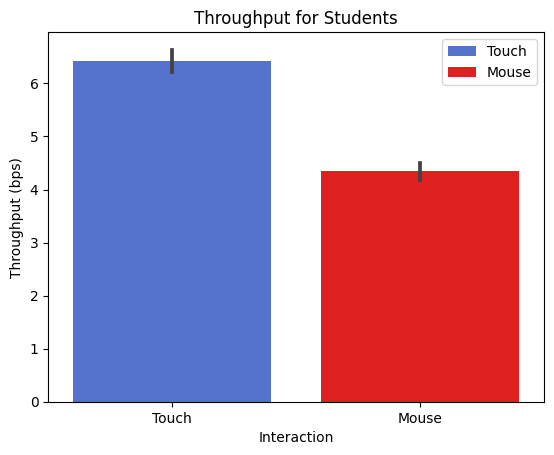

In [206]:
# Filter the data for Group G02
touch_data = touch_students_tp_qo_df[touch_students_tp_qo_df['Group'] == 'G01']
mouse_data = mouse_students_tp_qo_df[mouse_students_tp_qo_df['Group'] == 'G01']

# Concatenate the data from touch and mouse interactions
group_data = pd.concat([touch_data, mouse_data])

# Replace missing values with zeros
group_data['TP'] = group_data['TP'].fillna(0)

# Define the desired colors
colors = ["royalblue", "red"]

# Create the plot using seaborn and set the color palette
ax = sns.barplot(x='App', y='TP', hue='App', data=group_data, dodge=False, palette=colors)

# Set the labels and title of the plot
plt.xlabel("Interaction")
plt.ylabel("Throughput (bps)")
plt.title("Throughput for Students")

# Change the x-axis labels to uppercase starting letters
ax.set_xticklabels(['Touch', 'Mouse'])

# Change the legend labels to uppercase starting letters
handles, labels = ax.get_legend_handles_labels()
labels = ['Touch', 'Mouse']
ax.legend(handles, labels)

# Show the plot
plt.show()


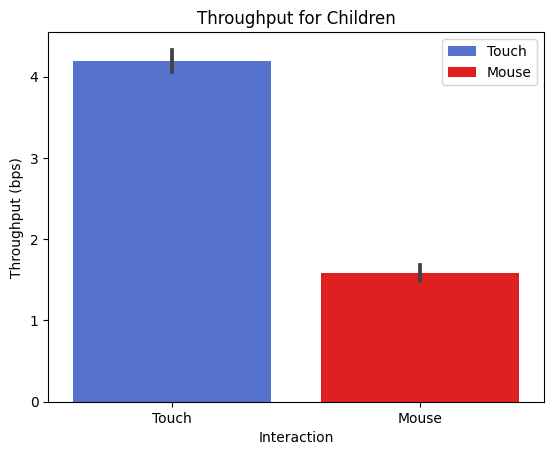

In [207]:
# Filter the data for Group G02
touch_data = touch_children_tp_qo_df[touch_children_tp_qo_df['Group'] == 'G02']
mouse_data = mouse_children_tp_qo_df[mouse_children_tp_qo_df['Group'] == 'G02']

# Concatenate the data from touch and mouse interactions
group_data = pd.concat([touch_data, mouse_data])

# Replace missing values with zeros
group_data['TP'] = group_data['TP'].fillna(0)

# Define the desired colors
colors = ["royalblue", "red"]

# Create the plot using seaborn
ax = sns.barplot(x='App', y='TP', hue='App', data=group_data, dodge=False, palette=colors)

# Set the labels and title of the plot
plt.xlabel("Interaction")
plt.ylabel("Throughput (bps)")
plt.title("Throughput for Children")

# Change the x-axis labels to uppercase starting letters
ax.set_xticklabels(['Touch', 'Mouse'])

# Change the legend labels to uppercase starting letters
handles, labels = ax.get_legend_handles_labels()
labels = ['Touch', 'Mouse']
ax.legend(handles, labels)

# Show the plot
plt.show()


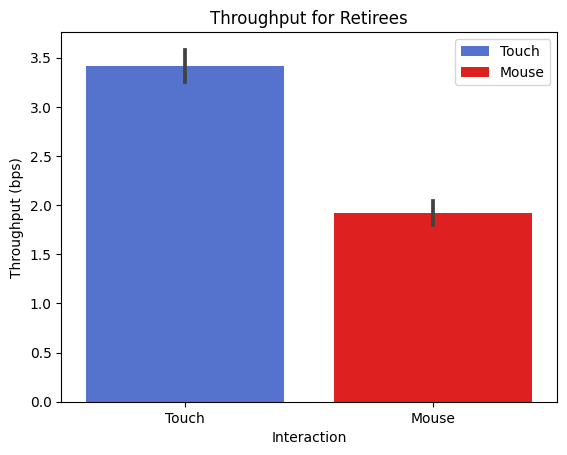

In [208]:
# Filter the data for Group G02
touch_data = touch_retirees_tp_qo_df[touch_retirees_tp_qo_df['Group'] == 'G03']
mouse_data = mouse_retirees_tp_qo_df[mouse_retirees_tp_qo_df['Group'] == 'G03']

# Concatenate the data from touch and mouse interactions
group_data = pd.concat([touch_data, mouse_data])

# Replace missing values with zeros
group_data['TP'] = group_data['TP'].fillna(0)

# Define the desired colors
colors = ["royalblue", "red"]

# Create the plot using seaborn
ax = sns.barplot(x='App', y='TP', hue='App', data=group_data, dodge=False, palette=colors)

# Set the labels and title of the plot
plt.xlabel("Interaction")
plt.ylabel("Throughput (bps)")
plt.title("Throughput for Retirees")

# Change the x-axis labels to uppercase starting letters
ax.set_xticklabels(['Touch', 'Mouse'])

# Change the legend labels to uppercase starting letters
handles, labels = ax.get_legend_handles_labels()
labels = ['Touch', 'Mouse']
ax.legend(handles, labels)

# Show the plot
plt.show()


## ER

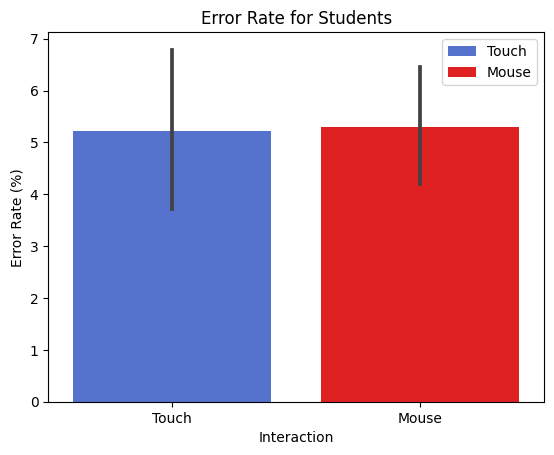

In [209]:
# Filter the data for Group G02
touch_data = touch_students_er_qo_df[touch_students_er_qo_df['Group'] == 'G01']
mouse_data = mouse_students_er_qo_df[mouse_students_er_qo_df['Group'] == 'G01']

# Concatenate the data from touch and mouse interactions
group_data = pd.concat([touch_data, mouse_data])

# Define the desired colors
colors = ["royalblue", "red"]

# Create the plot using seaborn and set the color palette
ax = sns.barplot(x='App', y='ER', hue='App', data=group_data, dodge=False, palette=colors)

# Set the labels and title of the plot
plt.xlabel("Interaction")
plt.ylabel("Error Rate (%)")
plt.title("Error Rate for Students")

# Change the x-axis labels to uppercase starting letters
ax.set_xticklabels(['Touch', 'Mouse'])

# Change the legend labels to uppercase starting letters
handles, labels = ax.get_legend_handles_labels()
labels = ['Touch', 'Mouse']
ax.legend(handles, labels)

# Show the plot
plt.show()


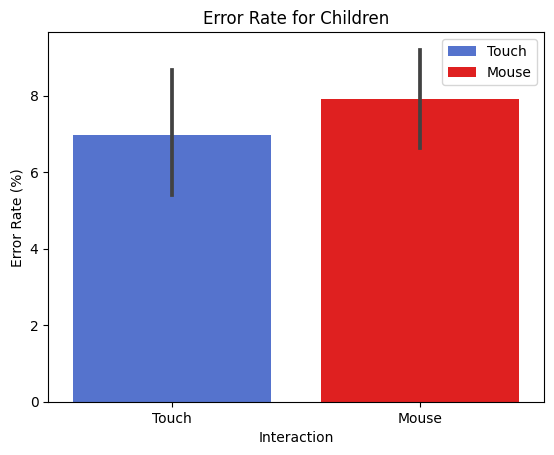

In [210]:
# Filter the data for Group G02
touch_data = touch_children_er_qo_df[touch_children_er_qo_df['Group'] == 'G02']
mouse_data = mouse_children_er_qo_df[mouse_children_er_qo_df['Group'] == 'G02']

# Concatenate the data from touch and mouse interactions
group_data = pd.concat([touch_data, mouse_data])

# Define the desired colors
colors = ["royalblue", "red"]

# Create the plot using seaborn and set the color palette
ax = sns.barplot(x='App', y='ER', hue='App', data=group_data, dodge=False, palette=colors)

# Set the labels and title of the plot
plt.xlabel("Interaction")
plt.ylabel("Error Rate (%)")
plt.title("Error Rate for Children")

# Change the x-axis labels to uppercase starting letters
ax.set_xticklabels(['Touch', 'Mouse'])

# Change the legend labels to uppercase starting letters
handles, labels = ax.get_legend_handles_labels()
labels = ['Touch', 'Mouse']
ax.legend(handles, labels)

# Show the plot
plt.show()


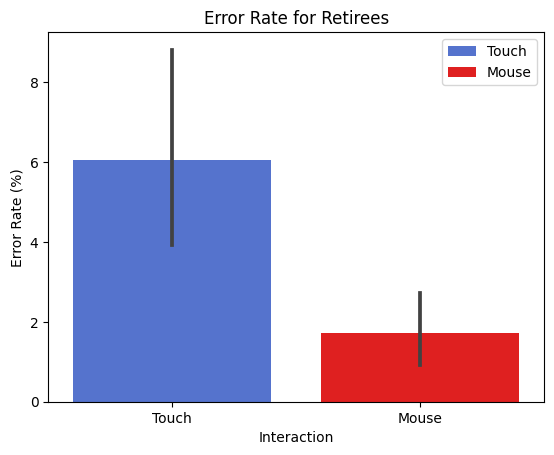

In [211]:
# Filter the data for Group G02
touch_data = touch_retirees_er_qo_df[touch_retirees_er_qo_df['Group'] == 'G03']
mouse_data = mouse_retirees_er_qo_df[mouse_retirees_er_qo_df['Group'] == 'G03']

# Concatenate the data from touch and mouse interactions
group_data = pd.concat([touch_data, mouse_data])

# Define the desired colors
colors = ["royalblue", "red"]

# Create the plot using seaborn and set the color palette
ax = sns.barplot(x='App', y='ER', hue='App', data=group_data, dodge=False, palette=colors)

# Set the labels and title of the plot
plt.xlabel("Interaction")
plt.ylabel("Error Rate (%)")
plt.title("Error Rate for Retirees")

# Change the x-axis labels to uppercase starting letters
ax.set_xticklabels(['Touch', 'Mouse'])

# Change the legend labels to uppercase starting letters
handles, labels = ax.get_legend_handles_labels()
labels = ['Touch', 'Mouse']
ax.legend(handles, labels)

# Show the plot
plt.show()


## Correlation and significance - TP, ER and MT




### cleaned_df - MT

In [212]:
# Perform linear regression analysis for touch data
print("Touch:")
for variable in ['Age', 'Gender', 'IT-experience']:
    x_values = cleaned_df.loc[cleaned_df['App'] == 'touch', variable]
    if x_values.nunique() == 1:
        print(f"{variable}: All values are identical.")
    else:
        x_values = x_values.dropna()  # Exclude any missing values
        if len(x_values) > 0:
            slope, intercept, r_value, p_value, std_err = linregress(x_values, cleaned_df.loc[cleaned_df['App'] == 'touch', 'MT'])
            print(f"{variable}: p-value = {p_value:.4f}, r-value = {r_value:.4f}")
        else:
            print(f"{variable}: No valid data points.")

# Perform linear regression analysis for mouse data
print("Mouse:")
for variable in ['Age', 'Gender', 'IT-experience']:
    x_values = cleaned_df.loc[cleaned_df['App'] == 'mouse', variable]
    if x_values.nunique() == 1:
        print(f"{variable}: All values are identical.")
    else:
        x_values = x_values.dropna()  # Exclude any missing values
        if len(x_values) > 0:
            slope, intercept, r_value, p_value, std_err = linregress(x_values, cleaned_df.loc[cleaned_df['App'] == 'mouse', 'MT'])
            print(f"{variable}: p-value = {p_value:.4f}, r-value = {r_value:.4f}")
        else:
            print(f"{variable}: No valid data points.")


Touch:
Age: p-value = 0.0000, r-value = 0.4837
Gender: p-value = 0.0000, r-value = -0.3196
IT-experience: p-value = 0.0000, r-value = -0.4657
Mouse:
Age: p-value = 0.0043, r-value = 0.1217
Gender: p-value = 0.0000, r-value = -0.2320
IT-experience: p-value = 0.0000, r-value = -0.4063


### ER

### cleaned_df - ER

In [213]:
# Perform linear regression analysis for touch data
print("Touch:")
for variable in ['Age', 'Gender', 'IT-experience']:
    x_values = cleaned_df.loc[cleaned_df['App'] == 'touch', variable]
    if x_values.nunique() == 1:
        print(f"{variable}: All values are identical.")
    else:
        x_values = x_values.dropna()  # Exclude any missing values
        if len(x_values) > 0:
            slope, intercept, r_value, p_value, std_err = linregress(x_values, cleaned_df.loc[cleaned_df['App'] == 'touch', 'ER'])
            print(f"{variable}: p-value = {p_value:.4f}, r-value = {r_value:.4f}")
        else:
            print(f"{variable}: No valid data points.")

# Perform linear regression analysis for mouse data
print("Mouse:")
for variable in ['Age', 'Gender', 'IT-experience']:
    x_values = cleaned_df.loc[cleaned_df['App'] == 'mouse', variable]
    if x_values.nunique() == 1:
        print(f"{variable}: All values are identical.")
    else:
        x_values = x_values.dropna()  # Exclude any missing values
        if len(x_values) > 0:
            slope, intercept, r_value, p_value, std_err = linregress(x_values, cleaned_df.loc[cleaned_df['App'] == 'mouse', 'ER'])
            print(f"{variable}: p-value = {p_value:.4f}, r-value = {r_value:.4f}")
        else:
            print(f"{variable}: No valid data points.")


Touch:
Age: p-value = 0.3087, r-value = 0.0435
Gender: p-value = 0.3560, r-value = 0.0395
IT-experience: p-value = 0.0619, r-value = -0.0797
Mouse:
Age: p-value = 0.0000, r-value = -0.1754
Gender: p-value = 0.1897, r-value = 0.0561
IT-experience: p-value = 0.4258, r-value = 0.0341


### TP

### cleaned_df - TP

In [214]:
# Perform linear regression analysis for touch data
print("Touch:")
for variable in ['Age', 'Gender', 'IT-experience']:
    x_values = cleaned_df.loc[cleaned_df['App'] == 'touch', variable]
    if x_values.nunique() == 1:
        print(f"{variable}: All values are identical.")
    else:
        x_values = x_values.dropna()  # Exclude any missing values
        if len(x_values) > 0:
            slope, intercept, r_value, p_value, std_err = linregress(x_values, cleaned_df.loc[cleaned_df['App'] == 'touch', 'TP'])
            print(f"{variable}: p-value = {p_value:.4f}, r-value = {r_value:.4f}")
        else:
            print(f"{variable}: No valid data points.")

# Perform linear regression analysis for mouse data
print("Mouse:")
for variable in ['Age', 'Gender', 'IT-experience']:
    x_values = cleaned_df.loc[cleaned_df['App'] == 'mouse', variable]
    if x_values.nunique() == 1:
        print(f"{variable}: All values are identical.")
    else:
        x_values = x_values.dropna()  # Exclude any missing values
        if len(x_values) > 0:
            slope, intercept, r_value, p_value, std_err = linregress(x_values, cleaned_df.loc[cleaned_df['App'] == 'mouse', 'TP'])
            print(f"{variable}: p-value = {p_value:.4f}, r-value = {r_value:.4f}")
        else:
            print(f"{variable}: No valid data points.")


Touch:
Age: p-value = 0.0000, r-value = -0.3239
Gender: p-value = 0.0000, r-value = 0.2516
IT-experience: p-value = 0.0000, r-value = 0.4441
Mouse:
Age: p-value = 0.0577, r-value = -0.0810
Gender: p-value = 0.0000, r-value = 0.2452
IT-experience: p-value = 0.0000, r-value = 0.4424


## Standard deviation and averages

### Averages MT, TP, ER

In [215]:
# Calculate averages and standard deviations for TP, MT, and ER variables in each dataframe without outliers

# Students - Touch
tp_avg_students_touch_tp_qo = touch_students_tp_qo_df['TP'].mean()
tp_std_students_touch_tp_qo = touch_students_tp_qo_df['TP'].std()
mt_avg_students_touch_mt_qo = touch_students_mt_qo_df['MT'].mean()
mt_std_students_touch_mt_qo = touch_students_mt_qo_df['MT'].std()
er_avg_students_touch_er_qo = touch_students_er_qo_df['ER'].mean()
er_std_students_touch_er_qo = touch_students_er_qo_df['ER'].std()

# Students - Mouse
tp_avg_students_mouse_tp_qo = mouse_students_tp_qo_df['TP'].mean()
tp_std_students_mouse_tp_qo = mouse_students_tp_qo_df['TP'].std()
mt_avg_students_mouse_mt_qo = mouse_students_mt_qo_df['MT'].mean()
mt_std_students_mouse_mt_qo = mouse_students_mt_qo_df['MT'].std()
er_avg_students_mouse_er_qo = mouse_students_er_qo_df['ER'].mean()
er_std_students_mouse_er_qo = mouse_students_er_qo_df['ER'].std()

# Children - Touch
tp_avg_children_touch_tp_qo = touch_children_tp_qo_df['TP'].mean()
tp_std_children_touch_tp_qo = touch_children_tp_qo_df['TP'].std()
mt_avg_children_touch_mt_qo = touch_children_mt_qo_df['MT'].mean()
mt_std_children_touch_mt_qo = touch_children_mt_qo_df['MT'].std()
er_avg_children_touch_er_qo = touch_children_er_qo_df['ER'].mean()
er_std_children_touch_er_qo = touch_children_er_qo_df['ER'].std()

# Children - Mouse
tp_avg_children_mouse_tp_qo = mouse_children_tp_qo_df['TP'].mean()
tp_std_children_mouse_tp_qo = mouse_children_tp_qo_df['TP'].std()
mt_avg_children_mouse_mt_qo = mouse_children_mt_qo_df['MT'].mean()
mt_std_children_mouse_mt_qo = mouse_children_mt_qo_df['MT'].std()
er_avg_children_mouse_er_qo = mouse_children_er_qo_df['ER'].mean()
er_std_children_mouse_er_qo = mouse_children_er_qo_df['ER'].std()

# Retirees - Touch
tp_avg_retirees_touch_tp_qo = touch_retirees_tp_qo_df['TP'].mean()
tp_std_retirees_touch_tp_qo = touch_retirees_tp_qo_df['TP'].std()
mt_avg_retirees_touch_mt_qo = touch_retirees_mt_qo_df['MT'].mean()
mt_std_retirees_touch_mt_qo = touch_retirees_mt_qo_df['MT'].std()
er_avg_retirees_touch_er_qo = touch_retirees_er_qo_df['ER'].mean()
er_std_retirees_touch_er_qo = touch_retirees_er_qo_df['ER'].std()

# Retirees - Mouse
tp_avg_retirees_mouse_tp_qo = mouse_retirees_tp_qo_df['TP'].mean()
tp_std_retirees_mouse_tp_qo = mouse_retirees_tp_qo_df['TP'].std()
mt_avg_retirees_mouse_mt_qo = mouse_retirees_mt_qo_df['MT'].mean()
mt_std_retirees_mouse_mt_qo = mouse_retirees_mt_qo_df['MT'].std()
er_avg_retirees_mouse_er_qo = mouse_retirees_er_qo_df['ER'].mean()
er_std_retirees_mouse_er_qo = mouse_retirees_er_qo_df['ER'].std()

# Display averages and standard deviations

print("Students - Touch (TP, MT, ER):")
print("TP Average:", tp_avg_students_touch_tp_qo)
print("TP Standard Deviation:", tp_std_students_touch_tp_qo)
print("MT Average:", mt_avg_students_touch_mt_qo)
print("MT Standard Deviation:", mt_std_students_touch_mt_qo)
print("ER Average:", er_avg_students_touch_er_qo)
print("ER Standard Deviation:", er_std_students_touch_er_qo)
print()

print("Students - Mouse (TP, MT, ER):")
print("TP Average:", tp_avg_students_mouse_tp_qo)
print("TP Standard Deviation:", tp_std_students_mouse_tp_qo)
print("MT Average:", mt_avg_students_mouse_mt_qo)
print("MT Standard Deviation:", mt_std_students_mouse_mt_qo)
print("ER Average:", er_avg_students_mouse_er_qo)
print("ER Standard Deviation:", er_std_students_mouse_er_qo)
print()

print("Children - Touch (TP, MT, ER):")
print("TP Average:", tp_avg_children_touch_tp_qo)
print("TP Standard Deviation:", tp_std_children_touch_tp_qo)
print("MT Average:", mt_avg_children_touch_mt_qo)
print("MT Standard Deviation:", mt_std_children_touch_mt_qo)
print("ER Average:", er_avg_children_touch_er_qo)
print("ER Standard Deviation:", er_std_children_touch_er_qo)
print()

print("Children - Mouse (TP, MT, ER):")
print("TP Average:", tp_avg_children_mouse_tp_qo)
print("TP Standard Deviation:", tp_std_children_mouse_tp_qo)
print("MT Average:", mt_avg_children_mouse_mt_qo)
print("MT Standard Deviation:", mt_std_children_mouse_mt_qo)
print("ER Average:", er_avg_children_mouse_er_qo)
print("ER Standard Deviation:", er_std_children_mouse_er_qo)
print()

print("Retirees - Touch (TP, MT, ER):")
print("TP Average:", tp_avg_retirees_touch_tp_qo)
print("TP Standard Deviation:", tp_std_retirees_touch_tp_qo)
print("MT Average:", mt_avg_retirees_touch_mt_qo)
print("MT Standard Deviation:", mt_std_retirees_touch_mt_qo)
print("ER Average:", er_avg_retirees_touch_er_qo)
print("ER Standard Deviation:", er_std_retirees_touch_er_qo)
print()

print("Retirees - Mouse (TP, MT, ER):")
print("TP Average:", tp_avg_retirees_mouse_tp_qo)
print("TP Standard Deviation:", tp_std_retirees_mouse_tp_qo)
print("MT Average:", mt_avg_retirees_mouse_mt_qo)
print("MT Standard Deviation:", mt_std_retirees_mouse_mt_qo)
print("ER Average:", er_avg_retirees_mouse_er_qo)
print("ER Standard Deviation:", er_std_retirees_mouse_er_qo)


Students - Touch (TP, MT, ER):
TP Average: 6.423917525773196
TP Standard Deviation: 1.5216718081138108
MT Average: 455.9827918781726
MT Standard Deviation: 92.69119903415933
ER Average: 5.222857142857142
ER Standard Deviation: 10.823640731582469

Students - Mouse (TP, MT, ER):
TP Average: 4.340397727272728
TP Standard Deviation: 1.0669906202803443
MT Average: 597.1777319587628
MT Standard Deviation: 164.19986935556233
ER Average: 5.295958549222798
ER Standard Deviation: 7.779689317271794

Children - Touch (TP, MT, ER):
TP Average: 4.194747474747475
TP Standard Deviation: 0.9846237586304633
MT Average: 643.2679601990051
MT Standard Deviation: 133.62754432869897
ER Average: 6.969387755102041
ER Standard Deviation: 12.07961120246513

Children - Mouse (TP, MT, ER):
TP Average: 1.5809852216748768
TP Standard Deviation: 0.6641133557499581
MT Average: 1396.0594179894183
MT Standard Deviation: 539.6978488658299
ER Average: 7.911666666666665
ER Standard Deviation: 9.6488835655175

Retirees - To

### Averages Age, Gender, IT-experience

In [216]:
# Calculate averages and standard deviations for Age, Gender, and IT-experience variables

# Students - Touch
age_avg_students_touch = touch_students_df['Age'].mean()
age_std_students_touch = touch_students_df['Age'].std()
gender_avg_students_touch = touch_students_df['Gender'].mean()
gender_std_students_touch = touch_students_df['Gender'].std()
it_exp_avg_students_touch = touch_students_df['IT-experience'].mean()
it_exp_std_students_touch = touch_students_df['IT-experience'].std()

# Students - Mouse
age_avg_students_mouse = mouse_students_df['Age'].mean()
age_std_students_mouse = mouse_students_df['Age'].std()
gender_avg_students_mouse = mouse_students_df['Gender'].mean()
gender_std_students_mouse = mouse_students_df['Gender'].std()
it_exp_avg_students_mouse = mouse_students_df['IT-experience'].mean()
it_exp_std_students_mouse = mouse_students_df['IT-experience'].std()

# Children - Touch
age_avg_children_touch = touch_children_df['Age'].mean()
age_std_children_touch = touch_children_df['Age'].std()
gender_avg_children_touch = touch_children_df['Gender'].mean()
gender_std_children_touch = touch_children_df['Gender'].std()
it_exp_avg_children_touch = touch_children_df['IT-experience'].mean()
it_exp_std_children_touch = touch_children_df['IT-experience'].std()

# Children - Mouse
age_avg_children_mouse = mouse_children_df['Age'].mean()
age_std_children_mouse = mouse_children_df['Age'].std()
gender_avg_children_mouse = mouse_children_df['Gender'].mean()
gender_std_children_mouse = mouse_children_df['Gender'].std()
it_exp_avg_children_mouse = mouse_children_df['IT-experience'].mean()
it_exp_std_children_mouse = mouse_children_df['IT-experience'].std()

# Retirees - Touch
age_avg_retirees_touch = touch_retirees_df['Age'].mean()
age_std_retirees_touch = touch_retirees_df['Age'].std()
gender_avg_retirees_touch = touch_retirees_df['Gender'].mean()
gender_std_retirees_touch = touch_retirees_df['Gender'].std()
it_exp_avg_retirees_touch = touch_retirees_df['IT-experience'].mean()
it_exp_std_retirees_touch = touch_retirees_df['IT-experience'].std()

# Retirees - Mouse
age_avg_retirees_mouse = mouse_retirees_df['Age'].mean()
age_std_retirees_mouse = mouse_retirees_df['Age'].std()
gender_avg_retirees_mouse = mouse_retirees_df['Gender'].mean()
gender_std_retirees_mouse = mouse_retirees_df['Gender'].std()
it_exp_avg_retirees_mouse = mouse_retirees_df['IT-experience'].mean()
it_exp_std_retirees_mouse = mouse_retirees_df['IT-experience'].std()

# Display averages and standard deviations

print("Students - Touch (Age, Gender, IT-experience):")
print("Age Average:", age_avg_students_touch)
print("Age Standard Deviation:", age_std_students_touch)
print("Gender Average:", gender_avg_students_touch)
print("Gender Standard Deviation:", gender_std_students_touch)
print("IT-experience Average:", it_exp_avg_students_touch)
print("IT-experience Standard Deviation:", it_exp_std_students_touch)
print()

print("Students - Mouse (Age, Gender, IT-experience):")
print("Age Average:", age_avg_students_mouse)
print("Age Standard Deviation:", age_std_students_mouse)
print("Gender Average:", gender_avg_students_mouse)
print("Gender Standard Deviation:", gender_std_students_mouse)
print("IT-experience Average:", it_exp_avg_students_mouse)
print("IT-experience Standard Deviation:", it_exp_std_students_mouse)
print()

print("Children - Touch (Age, Gender, IT-experience):")
print("Age Average:", age_avg_children_touch)
print("Age Standard Deviation:", age_std_children_touch)
print("Gender Average:", gender_avg_children_touch)
print("Gender Standard Deviation:", gender_std_children_touch)
print("IT-experience Average:", it_exp_avg_children_touch)
print("IT-experience Standard Deviation:", it_exp_std_children_touch)
print()

print("Children - Mouse (Age, Gender, IT-experience):")
print("Age Average:", age_avg_children_mouse)
print("Age Standard Deviation:", age_std_children_mouse)
print("Gender Average:", gender_avg_children_mouse)
print("Gender Standard Deviation:", gender_std_children_mouse)
print("IT-experience Average:", it_exp_avg_children_mouse)
print("IT-experience Standard Deviation:", it_exp_std_children_mouse)
print()

print("Retirees - Touch (Age, Gender, IT-experience):")
print("Age Average:", age_avg_retirees_touch)
print("Age Standard Deviation:", age_std_retirees_touch)
print("Gender Average:", gender_avg_retirees_touch)
print("Gender Standard Deviation:", gender_std_retirees_touch)
print("IT-experience Average:", it_exp_avg_retirees_touch)
print("IT-experience Standard Deviation:", it_exp_std_retirees_touch)
print()

print("Retirees - Mouse (Age, Gender, IT-experience):")
print("Age Average:", age_avg_retirees_mouse)
print("Age Standard Deviation:", age_std_retirees_mouse)
print("Gender Average:", gender_avg_retirees_mouse)
print("Gender Standard Deviation:", gender_std_retirees_mouse)
print("IT-experience Average:", it_exp_avg_retirees_mouse)
print("IT-experience Standard Deviation:", it_exp_std_retirees_mouse)


Students - Touch (Age, Gender, IT-experience):
Age Average: 25.09090909090909
Age Standard Deviation: 1.9333614455148398
Gender Average: 0.7727272727272727
Gender Standard Deviation: 0.4201324861908804
IT-experience Average: 3.0
IT-experience Standard Deviation: 0.0

Students - Mouse (Age, Gender, IT-experience):
Age Average: 25.09090909090909
Age Standard Deviation: 1.9333614455148398
Gender Average: 0.7727272727272727
Gender Standard Deviation: 0.4201324861908804
IT-experience Average: 3.0
IT-experience Standard Deviation: 0.0

Children - Touch (Age, Gender, IT-experience):
Age Average: 9.043478260869565
Age Standard Deviation: 0.6918691990562855
Gender Average: 0.6086956521739131
Gender Standard Deviation: 0.4892254023468047
IT-experience Average: 2.260869565217391
IT-experience Standard Deviation: 0.6751952018298721

Children - Mouse (Age, Gender, IT-experience):
Age Average: 9.043478260869565
Age Standard Deviation: 0.6918691990562855
Gender Average: 0.6086956521739131
Gender Stan

### Average Movement Time for Groups

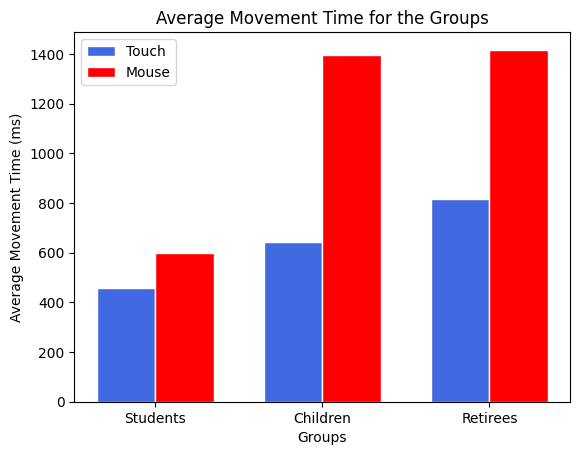

In [217]:
# Define the group labels and corresponding average values for MT
groups = ['Students', 'Children', 'Retirees']
mt_avg_touch = [mt_avg_students_touch_mt_qo, mt_avg_children_touch_mt_qo, mt_avg_retirees_touch_mt_qo]
mt_avg_mouse = [mt_avg_students_mouse_mt_qo, mt_avg_children_mouse_mt_qo, mt_avg_retirees_mouse_mt_qo]

# Set the bar width
bar_width = 0.35

# Set the positions of the bars on the x-axis
r1 = range(len(groups))
r2 = [x + bar_width for x in r1]

# Create the bar chart for touch data
plt.bar(r1, mt_avg_touch, color='royalblue', width=bar_width, edgecolor='white', label='Touch')

# Create the bar chart for mouse data
plt.bar(r2, mt_avg_mouse, color='red', width=bar_width, edgecolor='white', label='Mouse')

# Add labels, title, and legend
plt.xlabel('Groups')
plt.ylabel('Average Movement Time (ms)')
plt.title('Average Movement Time for the Groups')
plt.xticks([r + bar_width/2 for r in range(len(groups))], groups)
plt.legend()

# Display the chart
plt.show()


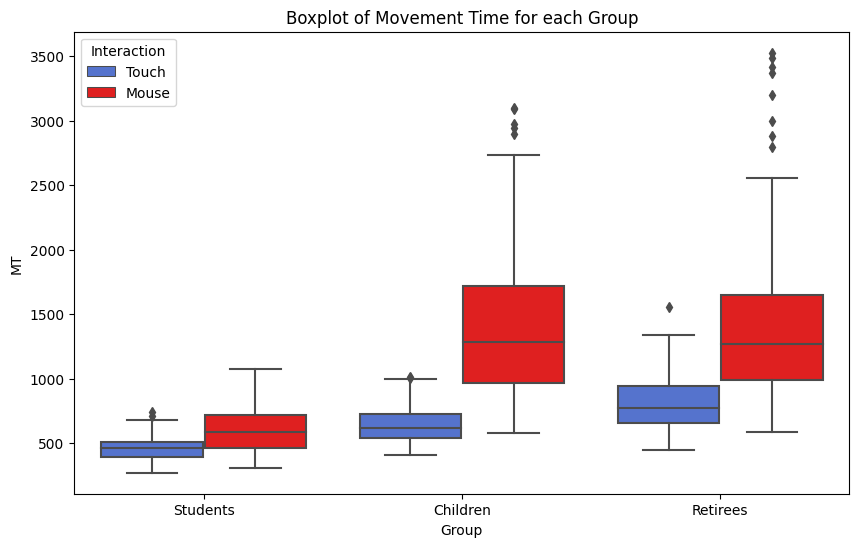

In [218]:
# Combine the dataframes for touch and mouse interactions
touch_dataframes = [touch_students_mt_qo_df, touch_children_mt_qo_df, touch_retirees_mt_qo_df]
mouse_dataframes = [mouse_students_mt_qo_df, mouse_children_mt_qo_df, mouse_retirees_mt_qo_df]
groups = ['Students', 'Children', 'Retirees']

combined_touch_df = pd.concat(touch_dataframes)
combined_mouse_df = pd.concat(mouse_dataframes)

# Combine the touch and mouse data into a single dataframe
combined_df = pd.concat([combined_touch_df, combined_mouse_df])
combined_df['Interaction'] = ['Touch'] * len(combined_touch_df) + ['Mouse'] * len(combined_mouse_df)

# Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=combined_df['Group'], y=combined_df['MT'], hue=combined_df['Interaction'], palette=['royalblue', 'red'])

plt.title('Boxplot of Movement Time for each Group')
plt.xlabel('Group')
plt.ylabel('MT')

# Set the x-tick labels
plt.xticks(ticks=range(len(groups)), labels=groups)

# Add a legend
plt.legend(title='Interaction')

# Display the plot
plt.show()


### Average Error Rate for Groups

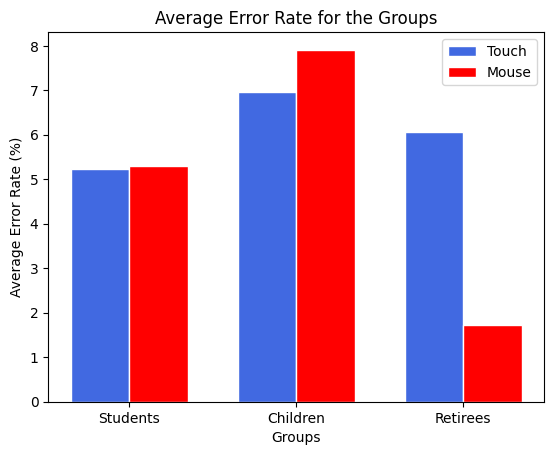

In [219]:
# Define the group labels and corresponding average values for ER
groups = ['Students', 'Children', 'Retirees']
er_avg_touch = [er_avg_students_touch_er_qo, er_avg_children_touch_er_qo, er_avg_retirees_touch_er_qo]
er_avg_mouse = [er_avg_students_mouse_er_qo, er_avg_children_mouse_er_qo, er_avg_retirees_mouse_er_qo]

# Set the bar width
bar_width = 0.35

# Set the positions of the bars on the x-axis
r1 = range(len(groups))
r2 = [x + bar_width for x in r1]

# Create the bar chart for touch data
plt.bar(r1, er_avg_touch, color='royalblue', width=bar_width, edgecolor='white', label='Touch')

# Create the bar chart for mouse data
plt.bar(r2, er_avg_mouse, color='red', width=bar_width, edgecolor='white', label='Mouse')

# Add labels, title, and legend
plt.xlabel('Groups')
plt.ylabel('Average Error Rate (%)')
plt.title('Average Error Rate for the Groups')
plt.xticks([r + bar_width/2 for r in range(len(groups))], groups)
plt.legend()

# Display the chart
plt.show()


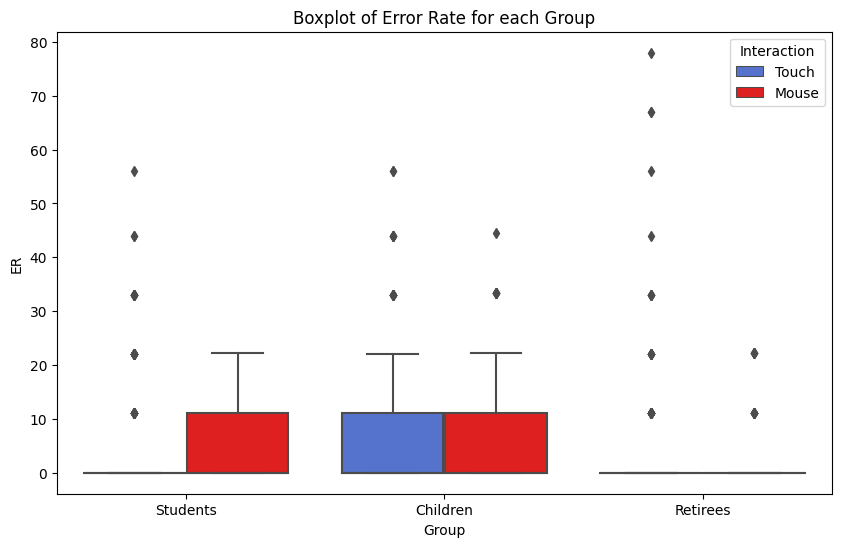

In [220]:
# Combine the dataframes for touch and mouse interactions
touch_dataframes = [touch_students_er_qo_df, touch_children_er_qo_df, touch_retirees_er_qo_df]
mouse_dataframes = [mouse_students_er_qo_df, mouse_children_er_qo_df, mouse_retirees_er_qo_df]
groups = ['Students', 'Children', 'Retirees']

combined_touch_df = pd.concat(touch_dataframes)
combined_mouse_df = pd.concat(mouse_dataframes)

# Combine the touch and mouse data into a single dataframe
combined_df = pd.concat([combined_touch_df, combined_mouse_df])
combined_df['Interaction'] = ['Touch'] * len(combined_touch_df) + ['Mouse'] * len(combined_mouse_df)

# Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=combined_df['Group'], y=combined_df['ER'], hue=combined_df['Interaction'], palette=['royalblue', 'red'])

plt.title('Boxplot of Error Rate for each Group')
plt.xlabel('Group')
plt.ylabel('ER')

# Set the x-tick labels
plt.xticks(ticks=range(len(groups)), labels=groups)

# Add a legend
plt.legend(title='Interaction')

# Display the plot
plt.show()


### Average Throughput for Groups

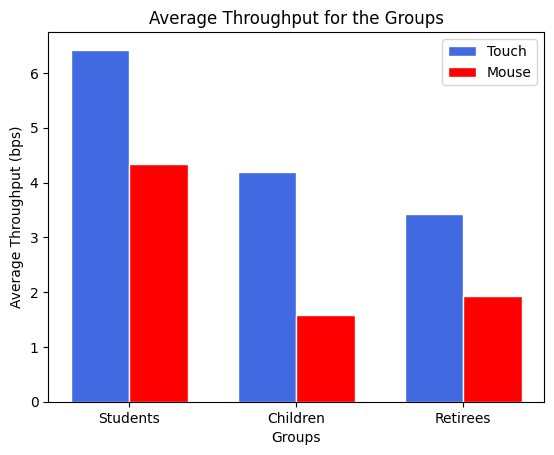

In [221]:
# Define the group labels and corresponding average values for TP
groups = ['Students', 'Children', 'Retirees']
tp_avg_touch = [tp_avg_students_touch_tp_qo, tp_avg_children_touch_tp_qo, tp_avg_retirees_touch_tp_qo]
tp_avg_mouse = [tp_avg_students_mouse_tp_qo, tp_avg_children_mouse_tp_qo, tp_avg_retirees_mouse_tp_qo]

# Set the bar width
bar_width = 0.35

# Set the positions of the bars on the x-axis
r1 = range(len(groups))
r2 = [x + bar_width for x in r1]

# Create the bar chart for touch data
plt.bar(r1, tp_avg_touch, color='royalblue', width=bar_width, edgecolor='white', label='Touch')

# Create the bar chart for mouse data
plt.bar(r2, tp_avg_mouse, color='red', width=bar_width, edgecolor='white', label='Mouse')

# Add labels, title, and legend
plt.xlabel('Groups')
plt.ylabel('Average Throughput (bps)')
plt.title('Average Throughput for the Groups')
plt.xticks([r + bar_width/2 for r in range(len(groups))], groups)
plt.legend()

# Display the chart
plt.show()


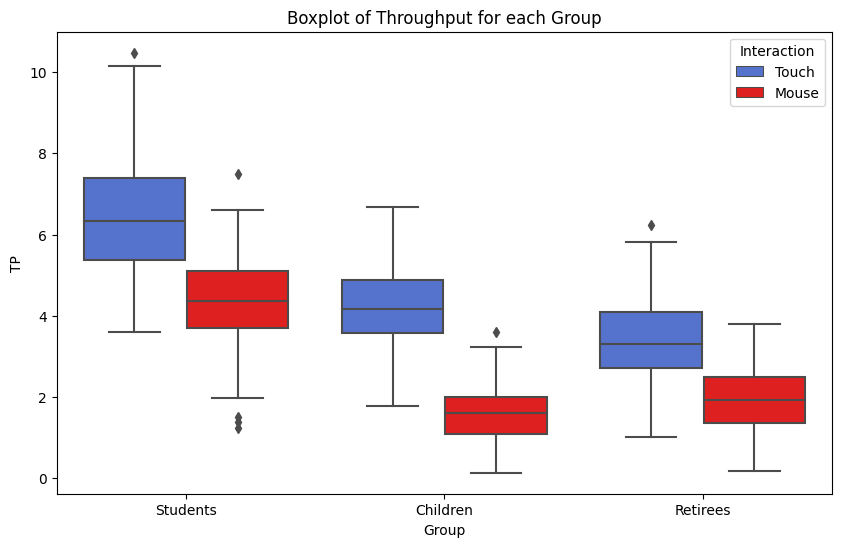

In [222]:
# Combine the dataframes for touch and mouse interactions
touch_dataframes = [touch_students_tp_qo_df, touch_children_tp_qo_df, touch_retirees_tp_qo_df]
mouse_dataframes = [mouse_students_tp_qo_df, mouse_children_tp_qo_df, mouse_retirees_tp_qo_df]
groups = ['Students', 'Children', 'Retirees']

combined_touch_df = pd.concat(touch_dataframes)
combined_mouse_df = pd.concat(mouse_dataframes)

# Combine the touch and mouse data into a single dataframe
combined_df = pd.concat([combined_touch_df, combined_mouse_df])
combined_df['Interaction'] = ['Touch'] * len(combined_touch_df) + ['Mouse'] * len(combined_mouse_df)

# Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=combined_df['Group'], y=combined_df['TP'], hue=combined_df['Interaction'], palette=['royalblue', 'red'])

plt.title('Boxplot of Throughput for each Group')
plt.xlabel('Group')
plt.ylabel('TP')

# Set the x-tick labels
plt.xticks(ticks=range(len(groups)), labels=groups)

# Add a legend
plt.legend(title='Interaction')

# Display the plot
plt.show()


## Gender

### MT

In [223]:
# List of dataframes to combine
dataframes = [touch_students_mt_qo_df, mouse_students_mt_qo_df, touch_children_mt_qo_df, mouse_children_mt_qo_df, touch_retirees_mt_qo_df, mouse_retirees_mt_qo_df]  # Add your dataframes here

# Modify the Gender variable in each dataframe
for df in dataframes:
    df['Gender'] = df['Gender'].replace({1.0: 'Male', 0.0: 'Female'})

# Concatenate the dataframes
combined_df = pd.concat(dataframes, ignore_index=True)

combined_df


,App,Participant,Group,A,W,ID,Ae,We,IDe,MT,ER,TP,UID,Age,Gender,IT-experience
0,touch,P01,G01,221.90,221.90,1.00,211.66,81.97,1.84,343.69,0.00,5.36,P01-G01,23,Male,3
1,touch,P01,G01,887.61,55.48,4.09,881.28,44.09,4.39,464.56,11.00,9.45,P01-G01,23,Male,3
2,touch,P01,G01,221.90,55.48,2.32,222.50,42.40,2.64,323.00,0.00,8.18,P01-G01,23,Male,3
3,touch,P01,G01,443.80,221.90,1.58,421.69,125.77,2.12,309.08,0.00,6.87,P01-G01,23,Male,3
4,touch,P01,G01,887.61,110.95,3.17,859.26,101.10,3.25,358.04,11.00,9.07,P01-G01,23,Male,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1043,mouse,P20,G03,240.00,30.00,3.17,237.95,36.76,2.90,1187.22,22.22,2.44,P20-G03,71,Male,3
1044,mouse,P20,G03,480.00,30.00,4.09,471.22,26.49,4.23,1432.33,0.00,2.95,P20-G03,71,Male,3
1045,mouse,P20,G03,120.00,60.00,1.58,130.92,35.36,2.23,797.67,0.00,2.80,P20-G03,71,Male,3
1046,mouse,P20,G03,240.00,120.00,1.58,213.79,90.73,1.75,833.22,0.00,2.10,P20-G03,71,Male,3


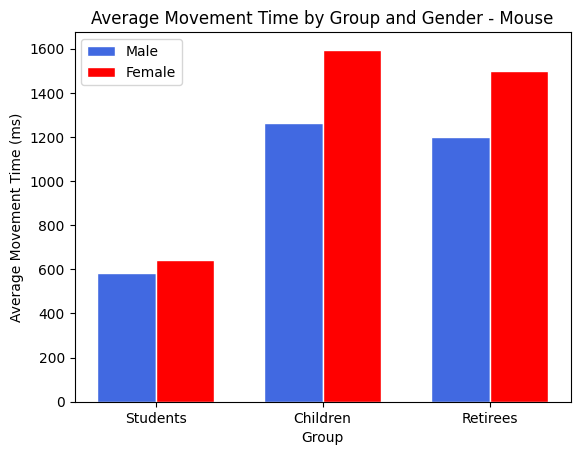

In [224]:
# Define the data for each group
students_male = mouse_students_mt_qo_df[mouse_students_mt_qo_df['Gender'] == 'Male']['MT']
students_female = mouse_students_mt_qo_df[mouse_students_mt_qo_df['Gender'] == 'Female']['MT']

children_male = mouse_children_mt_qo_df[mouse_children_mt_qo_df['Gender'] == 'Male']['MT']
children_female = mouse_children_mt_qo_df[mouse_children_mt_qo_df['Gender'] == 'Female']['MT']

retirees_male = mouse_retirees_mt_qo_df[mouse_retirees_mt_qo_df['Gender'] == 'Male']['MT']
retirees_female = mouse_retirees_mt_qo_df[mouse_retirees_mt_qo_df['Gender'] == 'Female']['MT']

x = ['Students', 'Children', 'Retirees']
y_male = [students_male.mean(), children_male.mean(), retirees_male.mean()]
y_female = [students_female.mean(), children_female.mean(), retirees_female.mean()]

# Set the bar width
bar_width = 0.35

# Set the positions of the bars on the x-axis
r1 = range(len(x))
r2 = [x + bar_width for x in r1]

# Create the bar chart for Male
plt.bar(r1, y_male, color='royalblue', width=bar_width, edgecolor='white', label='Male')

# Create the bar chart for Female
plt.bar(r2, y_female, color='red', width=bar_width, edgecolor='white', label='Female')

# Add labels, title, and legend
plt.xlabel('Group')
plt.ylabel('Average Movement Time (ms)')
plt.title('Average Movement Time by Group and Gender - Mouse')
plt.xticks([r + bar_width/2 for r in range(len(x))], x)
plt.legend()

# Display the plot
plt.show()


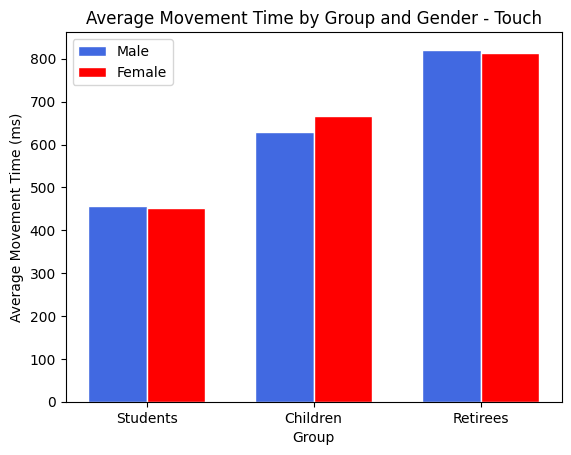

In [225]:
# Define the data for each group
students_male = touch_students_mt_qo_df[touch_students_mt_qo_df['Gender'] == 'Male']['MT']
students_female = touch_students_mt_qo_df[touch_students_mt_qo_df['Gender'] == 'Female']['MT']

children_male = touch_children_mt_qo_df[touch_children_mt_qo_df['Gender'] == 'Male']['MT']
children_female = touch_children_mt_qo_df[touch_children_mt_qo_df['Gender'] == 'Female']['MT']

retirees_male = touch_retirees_mt_qo_df[touch_retirees_mt_qo_df['Gender'] == 'Male']['MT']
retirees_female = touch_retirees_mt_qo_df[touch_retirees_mt_qo_df['Gender'] == 'Female']['MT']

x = ['Students', 'Children', 'Retirees']
y_male = [students_male.mean(), children_male.mean(), retirees_male.mean()]
y_female = [students_female.mean(), children_female.mean(), retirees_female.mean()]

# Set the bar width
bar_width = 0.35

# Set the positions of the bars on the x-axis
r1 = range(len(x))
r2 = [x + bar_width for x in r1]

# Create the bar chart for Male
plt.bar(r1, y_male, color='royalblue', width=bar_width, edgecolor='white', label='Male')

# Create the bar chart for Female
plt.bar(r2, y_female, color='red', width=bar_width, edgecolor='white', label='Female')

# Add labels, title, and legend
plt.xlabel('Group')
plt.ylabel('Average Movement Time (ms)')
plt.title('Average Movement Time by Group and Gender - Touch')
plt.xticks([r + bar_width/2 for r in range(len(x))], x)
plt.legend()

# Display the plot
plt.show()


### TP

In [226]:
# List of dataframes to combine
dataframes = [touch_students_tp_qo_df, mouse_students_tp_qo_df, touch_children_tp_qo_df, mouse_children_tp_qo_df, touch_retirees_tp_qo_df, mouse_retirees_tp_qo_df]  # Add your dataframes here

# Modify the Gender variable in each dataframe
for df in dataframes:
    df['Gender'] = df['Gender'].replace({1.0: 'Male', 0.0: 'Female'})

# Concatenate the dataframes
combined_df = pd.concat(dataframes, ignore_index=True)

combined_df

,App,Participant,Group,A,W,ID,Ae,We,IDe,MT,ER,TP,UID,Age,Gender,IT-experience
0,touch,P01,G01,221.90,221.90,1.00,211.66,81.97,1.84,343.69,0.00,5.36,P01-G01,23,Male,3
1,touch,P01,G01,887.61,55.48,4.09,881.28,44.09,4.39,464.56,11.00,9.45,P01-G01,23,Male,3
2,touch,P01,G01,221.90,55.48,2.32,222.50,42.40,2.64,323.00,0.00,8.18,P01-G01,23,Male,3
3,touch,P01,G01,443.80,221.90,1.58,421.69,125.77,2.12,309.08,0.00,6.87,P01-G01,23,Male,3
4,touch,P01,G01,887.61,110.95,3.17,859.26,101.10,3.25,358.04,11.00,9.07,P01-G01,23,Male,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048,mouse,P20,G03,240.00,30.00,3.17,237.95,36.76,2.90,1187.22,22.22,2.44,P20-G03,71,Male,3
1049,mouse,P20,G03,480.00,30.00,4.09,471.22,26.49,4.23,1432.33,0.00,2.95,P20-G03,71,Male,3
1050,mouse,P20,G03,120.00,60.00,1.58,130.92,35.36,2.23,797.67,0.00,2.80,P20-G03,71,Male,3
1051,mouse,P20,G03,240.00,120.00,1.58,213.79,90.73,1.75,833.22,0.00,2.10,P20-G03,71,Male,3


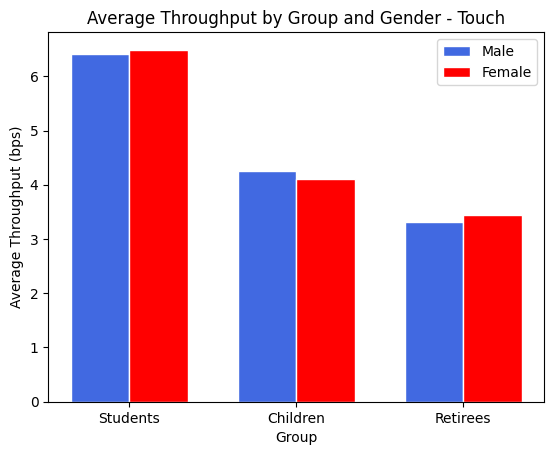

In [227]:
# Define the data for each group
students_male = touch_students_tp_qo_df[touch_students_tp_qo_df['Gender'] == 'Male']['TP']
students_female = touch_students_tp_qo_df[touch_students_tp_qo_df['Gender'] == 'Female']['TP']

children_male = touch_children_tp_qo_df[touch_children_tp_qo_df['Gender'] == 'Male']['TP']
children_female = touch_children_tp_qo_df[touch_children_tp_qo_df['Gender'] == 'Female']['TP']

retirees_male = touch_retirees_tp_qo_df[touch_retirees_tp_qo_df['Gender'] == 'Male']['TP']
retirees_female = touch_retirees_tp_qo_df[touch_retirees_tp_qo_df['Gender'] == 'Female']['TP']

x = ['Students', 'Children', 'Retirees']
y_male = [students_male.mean(), children_male.mean(), retirees_male.mean()]
y_female = [students_female.mean(), children_female.mean(), retirees_female.mean()]

# Set the bar width
bar_width = 0.35

# Set the positions of the bars on the x-axis
r1 = range(len(x))
r2 = [x + bar_width for x in r1]

# Create the bar chart for Male
plt.bar(r1, y_male, color='royalblue', width=bar_width, edgecolor='white', label='Male')

# Create the bar chart for Female
plt.bar(r2, y_female, color='red', width=bar_width, edgecolor='white', label='Female')

# Add labels, title, and legend
plt.xlabel('Group')
plt.ylabel('Average Throughput (bps)')
plt.title('Average Throughput by Group and Gender - Touch')
plt.xticks([r + bar_width/2 for r in range(len(x))], x)
plt.legend()

# Display the plot
plt.show()


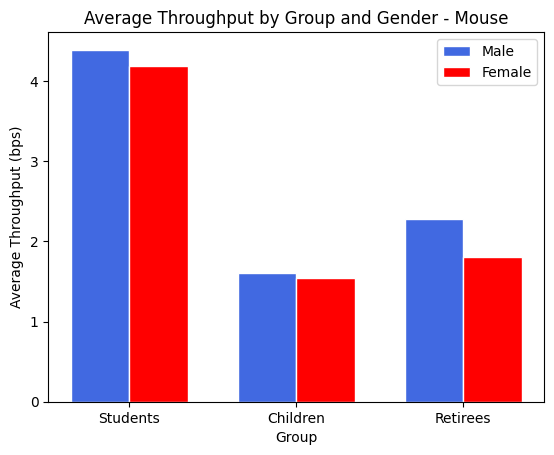

In [228]:
# Define the data for each group
students_male = mouse_students_tp_qo_df[mouse_students_tp_qo_df['Gender'] == 'Male']['TP']
students_female = mouse_students_tp_qo_df[mouse_students_tp_qo_df['Gender'] == 'Female']['TP']

children_male = mouse_children_tp_qo_df[mouse_children_tp_qo_df['Gender'] == 'Male']['TP']
children_female = mouse_children_tp_qo_df[mouse_children_tp_qo_df['Gender'] == 'Female']['TP']

retirees_male = mouse_retirees_tp_qo_df[mouse_retirees_tp_qo_df['Gender'] == 'Male']['TP']
retirees_female = mouse_retirees_tp_qo_df[mouse_retirees_tp_qo_df['Gender'] == 'Female']['TP']

x = ['Students', 'Children', 'Retirees']
y_male = [students_male.mean(), children_male.mean(), retirees_male.mean()]
y_female = [students_female.mean(), children_female.mean(), retirees_female.mean()]

# Set the bar width
bar_width = 0.35

# Set the positions of the bars on the x-axis
r1 = range(len(x))
r2 = [x + bar_width for x in r1]

# Create the bar chart for Male
plt.bar(r1, y_male, color='royalblue', width=bar_width, edgecolor='white', label='Male')

# Create the bar chart for Female
plt.bar(r2, y_female, color='red', width=bar_width, edgecolor='white', label='Female')

# Add labels, title, and legend
plt.xlabel('Group')
plt.ylabel('Average Throughput (bps)')
plt.title('Average Throughput by Group and Gender - Mouse')
plt.xticks([r + bar_width/2 for r in range(len(x))], x)
plt.legend()

# Display the plot
plt.show()


### ER

In [229]:
# List of dataframes to combine
dataframes = [touch_students_er_qo_df, mouse_students_er_qo_df, touch_children_er_qo_df, mouse_children_er_qo_df, touch_retirees_er_qo_df, mouse_retirees_er_qo_df]  # Add your dataframes here

# Modify the Gender variable in each dataframe
for df in dataframes:
    df['Gender'] = df['Gender'].replace({1.0: 'Male', 0.0: 'Female'})

# Concatenate the dataframes
combined_df = pd.concat(dataframes, ignore_index=True)

combined_df

,App,Participant,Group,A,W,ID,Ae,We,IDe,MT,ER,TP,UID,Age,Gender,IT-experience
0,touch,P01,G01,221.90,221.90,1.00,211.66,81.97,1.84,343.69,0.00,5.36,P01-G01,23,Male,3
1,touch,P01,G01,221.90,55.48,2.32,222.50,42.40,2.64,323.00,0.00,8.18,P01-G01,23,Male,3
2,touch,P01,G01,443.80,221.90,1.58,421.69,125.77,2.12,309.08,0.00,6.87,P01-G01,23,Male,3
3,touch,P01,G01,887.61,110.95,3.17,859.26,101.10,3.25,358.04,11.00,9.07,P01-G01,23,Male,3
4,touch,P01,G01,443.80,110.95,2.32,428.48,98.08,2.42,353.88,11.00,6.85,P01-G01,23,Male,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1012,mouse,P20,G03,240.00,30.00,3.17,237.95,36.76,2.90,1187.22,22.22,2.44,P20-G03,71,Male,3
1013,mouse,P20,G03,480.00,30.00,4.09,471.22,26.49,4.23,1432.33,0.00,2.95,P20-G03,71,Male,3
1014,mouse,P20,G03,120.00,60.00,1.58,130.92,35.36,2.23,797.67,0.00,2.80,P20-G03,71,Male,3
1015,mouse,P20,G03,240.00,120.00,1.58,213.79,90.73,1.75,833.22,0.00,2.10,P20-G03,71,Male,3


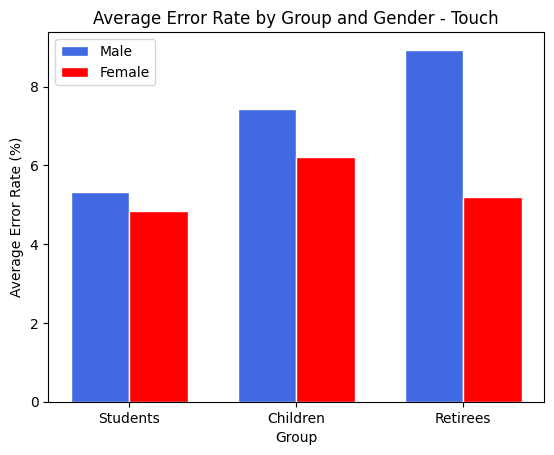

In [230]:
# Define the data for each group
students_male = touch_students_er_qo_df[touch_students_er_qo_df['Gender'] == 'Male']['ER']
students_female = touch_students_er_qo_df[touch_students_er_qo_df['Gender'] == 'Female']['ER']

children_male = touch_children_er_qo_df[touch_children_er_qo_df['Gender'] == 'Male']['ER']
children_female = touch_children_er_qo_df[touch_children_er_qo_df['Gender'] == 'Female']['ER']

retirees_male = touch_retirees_er_qo_df[touch_retirees_er_qo_df['Gender'] == 'Male']['ER']
retirees_female = touch_retirees_er_qo_df[touch_retirees_er_qo_df['Gender'] == 'Female']['ER']

x = ['Students', 'Children', 'Retirees']
y_male = [students_male.mean(), children_male.mean(), retirees_male.mean()]
y_female = [students_female.mean(), children_female.mean(), retirees_female.mean()]

# Set the bar width
bar_width = 0.35

# Set the positions of the bars on the x-axis
r1 = range(len(x))
r2 = [x + bar_width for x in r1]

# Create the bar chart for Male
plt.bar(r1, y_male, color='royalblue', width=bar_width, edgecolor='white', label='Male')

# Create the bar chart for Female
plt.bar(r2, y_female, color='red', width=bar_width, edgecolor='white', label='Female')

# Add labels, title, and legend
plt.xlabel('Group')
plt.ylabel('Average Error Rate (%)')
plt.title('Average Error Rate by Group and Gender - Touch')
plt.xticks([r + bar_width/2 for r in range(len(x))], x)
plt.legend()

# Display the plot
plt.show()


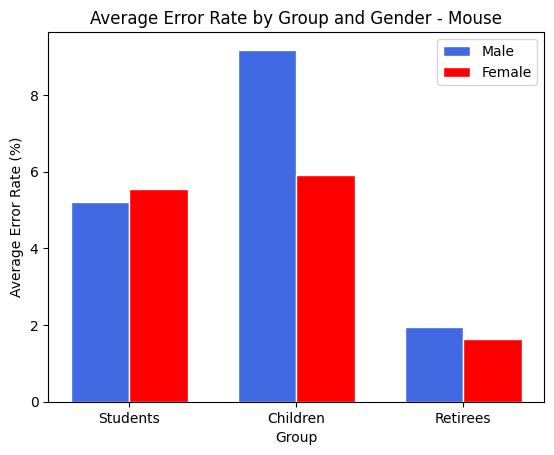

In [231]:
# Define the data for each group
students_male = mouse_students_er_qo_df[mouse_students_er_qo_df['Gender'] == 'Male']['ER']
students_female = mouse_students_er_qo_df[mouse_students_er_qo_df['Gender'] == 'Female']['ER']

children_male = mouse_children_er_qo_df[mouse_children_er_qo_df['Gender'] == 'Male']['ER']
children_female = mouse_children_er_qo_df[mouse_children_er_qo_df['Gender'] == 'Female']['ER']

retirees_male = mouse_retirees_er_qo_df[mouse_retirees_er_qo_df['Gender'] == 'Male']['ER']
retirees_female = mouse_retirees_er_qo_df[mouse_retirees_er_qo_df['Gender'] == 'Female']['ER']

x = ['Students', 'Children', 'Retirees']
y_male = [students_male.mean(), children_male.mean(), retirees_male.mean()]
y_female = [students_female.mean(), children_female.mean(), retirees_female.mean()]

# Set the bar width
bar_width = 0.35

# Set the positions of the bars on the x-axis
r1 = range(len(x))
r2 = [x + bar_width for x in r1]

# Create the bar chart for Male
plt.bar(r1, y_male, color='royalblue', width=bar_width, edgecolor='white', label='Male')

# Create the bar chart for Female
plt.bar(r2, y_female, color='red', width=bar_width, edgecolor='white', label='Female')

# Add labels, title, and legend
plt.xlabel('Group')
plt.ylabel('Average Error Rate (%)')
plt.title('Average Error Rate by Group and Gender - Mouse')
plt.xticks([r + bar_width/2 for r in range(len(x))], x)
plt.legend()

# Display the plot
plt.show()
